# Statistical Downscaling Toolbox

Workflow:
1. Data Extraction
2. Data Preprocessing
3. Predictor Definition
4. Statistical Model
5. Application: Future Wave Projections

In [1]:
# 0, Load all modules

# general imports
import numpy as np
import os
import pandas as pd
import csv
import copy
import sys
import xarray as xr
from netCDF4 import Dataset
from datetime import datetime, timedelta
import logging

# non-general imports 
# install matplotlib seperately (not included in the package)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
import matplotlib.colors
from matplotlib.ticker import MultipleLocator
import cartopy.crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# call the SDTOOlBox package and its the appropriate functions
sys.path.append(r'C:\checkouts\trunk') 
import SDToolBox
from SDToolBox import data_processing as dap
from SDToolBox import extract_data as exd
from SDToolBox import input_data as ind
from SDToolBox import output_data as oud
from SDToolBox import output_messages as ome
from SDToolBox import predictor_definition as pde
from SDToolBox import statistical_model as stm

# call help functions to get more info on the SDToolBox
help(SDToolBox)
#help(dap)
#help(exd)
#help(oud)

# plots in the notebook
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
c:\users\kras\anaconda3\envs\sdtoolbox_env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Help on package SDToolBox:

NAME
    SDToolBox

PACKAGE CONTENTS
    data_processing
    extract_data
    input_data
    output_data
    output_messages
    predictor_definition
    statistical_model

FILE
    c:\checkouts\trunk\sdtoolbox\__init__.py




# 1. Data Extraction

Make use of the following functions:
1. input_data (ind)
2. extract_data (exd)
3. output_data (oud)
4. (output_messages (ome))

Task 1a. Extract wave parameters (wave height, peak period, wave direction) at locations in 20m depth along the Dutch coast

In [2]:
# set up the folder where we want to extract data from
folder = r'C:\checkouts\trunk\doc\SDToolBox - Test Plan\study_case_NL\data'

# open the data in this script to get the info
DS = Dataset(os.path.join(folder,'NS_WAM_ERA5.nc'))

# check the entries within the .netCDF file
print('We can extract %s entries with the shape as per below:' %len(DS.variables))
station = list(np.array(DS.variables['station']))
variables = [] # saved names of the entries
for i in DS.variables:
    print(i, DS.variables[i].shape)
    variables.append(i)
    
# set the directory where to obtain the ERA5 and EC-EARTH data
dir_ERA5 = r'P:\metocean-data\open\ERA5\data\Global'
dir_earth = r'P:\11200665-c3s-codec\2_Hydro\DMI_meteo\meteo_1_Global'

We can extract 10 entries with the shape as per below:
station (19,)
time (149016,)
lat (19,)
lon (19,)
projection ()
SWH (149016, 19)
PP1D (149016, 19)
MP1 (149016, 19)
MWD (149016, 19)
WDW (149016, 19)


In [3]:
# get the coordinates of the WAM locations
lonWAM = DS.variables['lon'][:] # list with longitude positions
latWAM = DS.variables['lat'][:] # list with latitude positions 

coordsWAMWAVE = {'LON': [], 'LAT': []}
for i, j in zip(lonWAM, latWAM):
    coordsWAMWAVE['LON'].append(i)
    coordsWAMWAVE['LAT'].append(j)

# set other data variables    
varWAMWAVE = [v.lower() for v in variables[5:]] # list with the five wave parameters
timeWAMy = [1986] # single or multiple ints

In [5]:
# use the SDToolBox function to create input data
Input_DataWAMWAVE = ind.InputData(
    input_coordinates=coordsWAMWAVE,
    input_variables=varWAMWAVE,
    input_scenarios=['era5'],
    input_years=timeWAMy) # default is_gridded is false, referring to points

# use the SDToolBox function to extract data
Extract_Data_ERA5WAMWAVE = exd.ExtractData.get_era_5(dir_ERA5, Input_DataWAMWAVE)

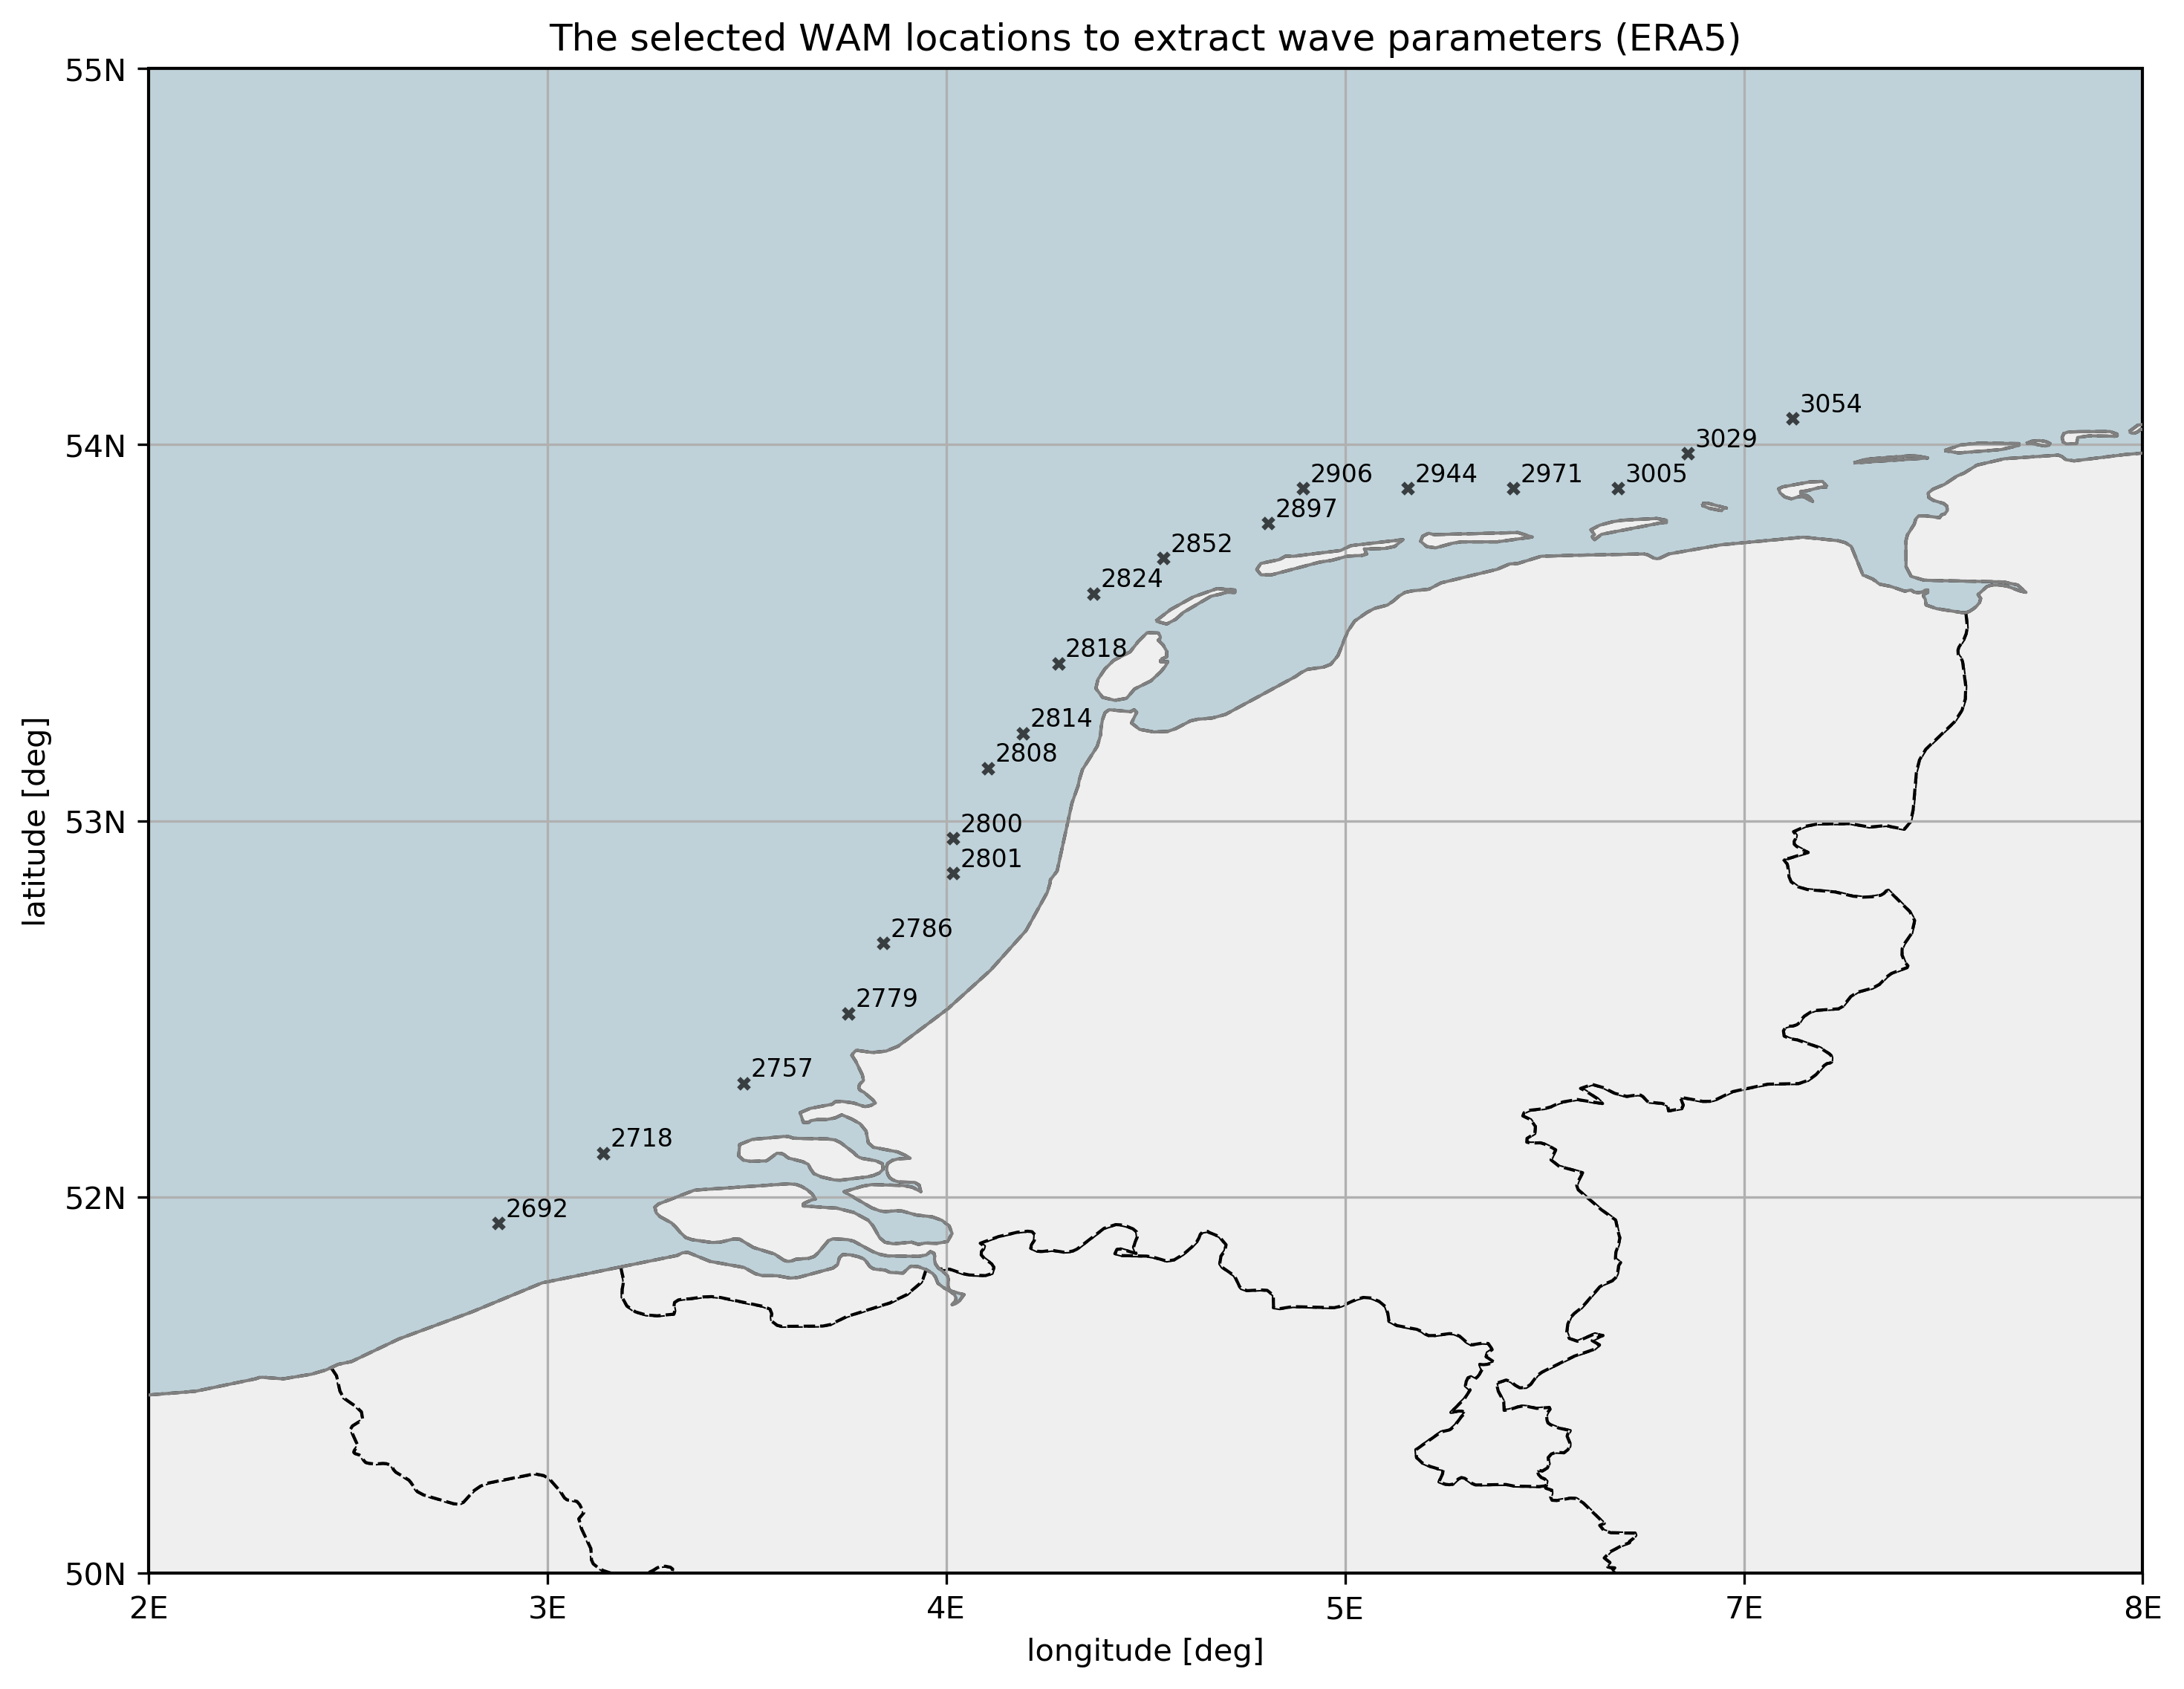

In [6]:
# plot the measurement station locations
fig = plt.figure(figsize=(16, 9), dpi=300, facecolor='white')

# world map
ax = plt.axes([0, 0.12, 0.83, 0.75],projection=cartopy.crs.PlateCarree())
ax.grid()

_ = ax.set_xlim(min(lonWAM)-1, max(lonWAM)+1)                 
_ = ax.set_ylim(min(latWAM)-1, max(latWAM)+1) 
_ = ax.set_xticks(np.linspace(min(lonWAM)-1, max(lonWAM)+1, num=6), crs=cartopy.crs.PlateCarree()) 
_ = ax.set_yticks(np.linspace(min(latWAM)-1, max(latWAM)+1, num=5), crs=cartopy.crs.PlateCarree()) 

# Set RGB value to ocean colour '#bfd2d9' has 191, G:210, B:217 as 10m ocean cartopy import gives errors
ax.imshow(np.tile(np.array([[[191, 210, 217]]], dtype=np.uint8), [2, 2, 1]), origin='upper', transform=cartopy.crs.PlateCarree(), extent=[-180, 180, -180, 180])

# create accurate plot using 10m data, note that this is unnecessary on global scale
text_font = {'size':'8'}
for i, j, k in zip(lonWAM, latWAM, station):
    ax.scatter(i, j, c='k', lw=0, marker='X', s=20, alpha=0.7, zorder=10)
    ax.text(i+0.02, j+0.02, "%s"%k, zorder=11, **text_font)
ax.set_title('The selected WAM locations to extract wave parameters (ERA5)')
ax.set_xlabel('longitude [deg]')
ax.set_ylabel('latitude [deg]')

# load features, add features and add axes
country_10m = cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m')
ax.add_feature(country_10m, edgecolor='k', linestyle='--', facecolor='#EEEFEE')
ax.coastlines(resolution='10m', color='grey', zorder=5);

lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='',
                                   dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

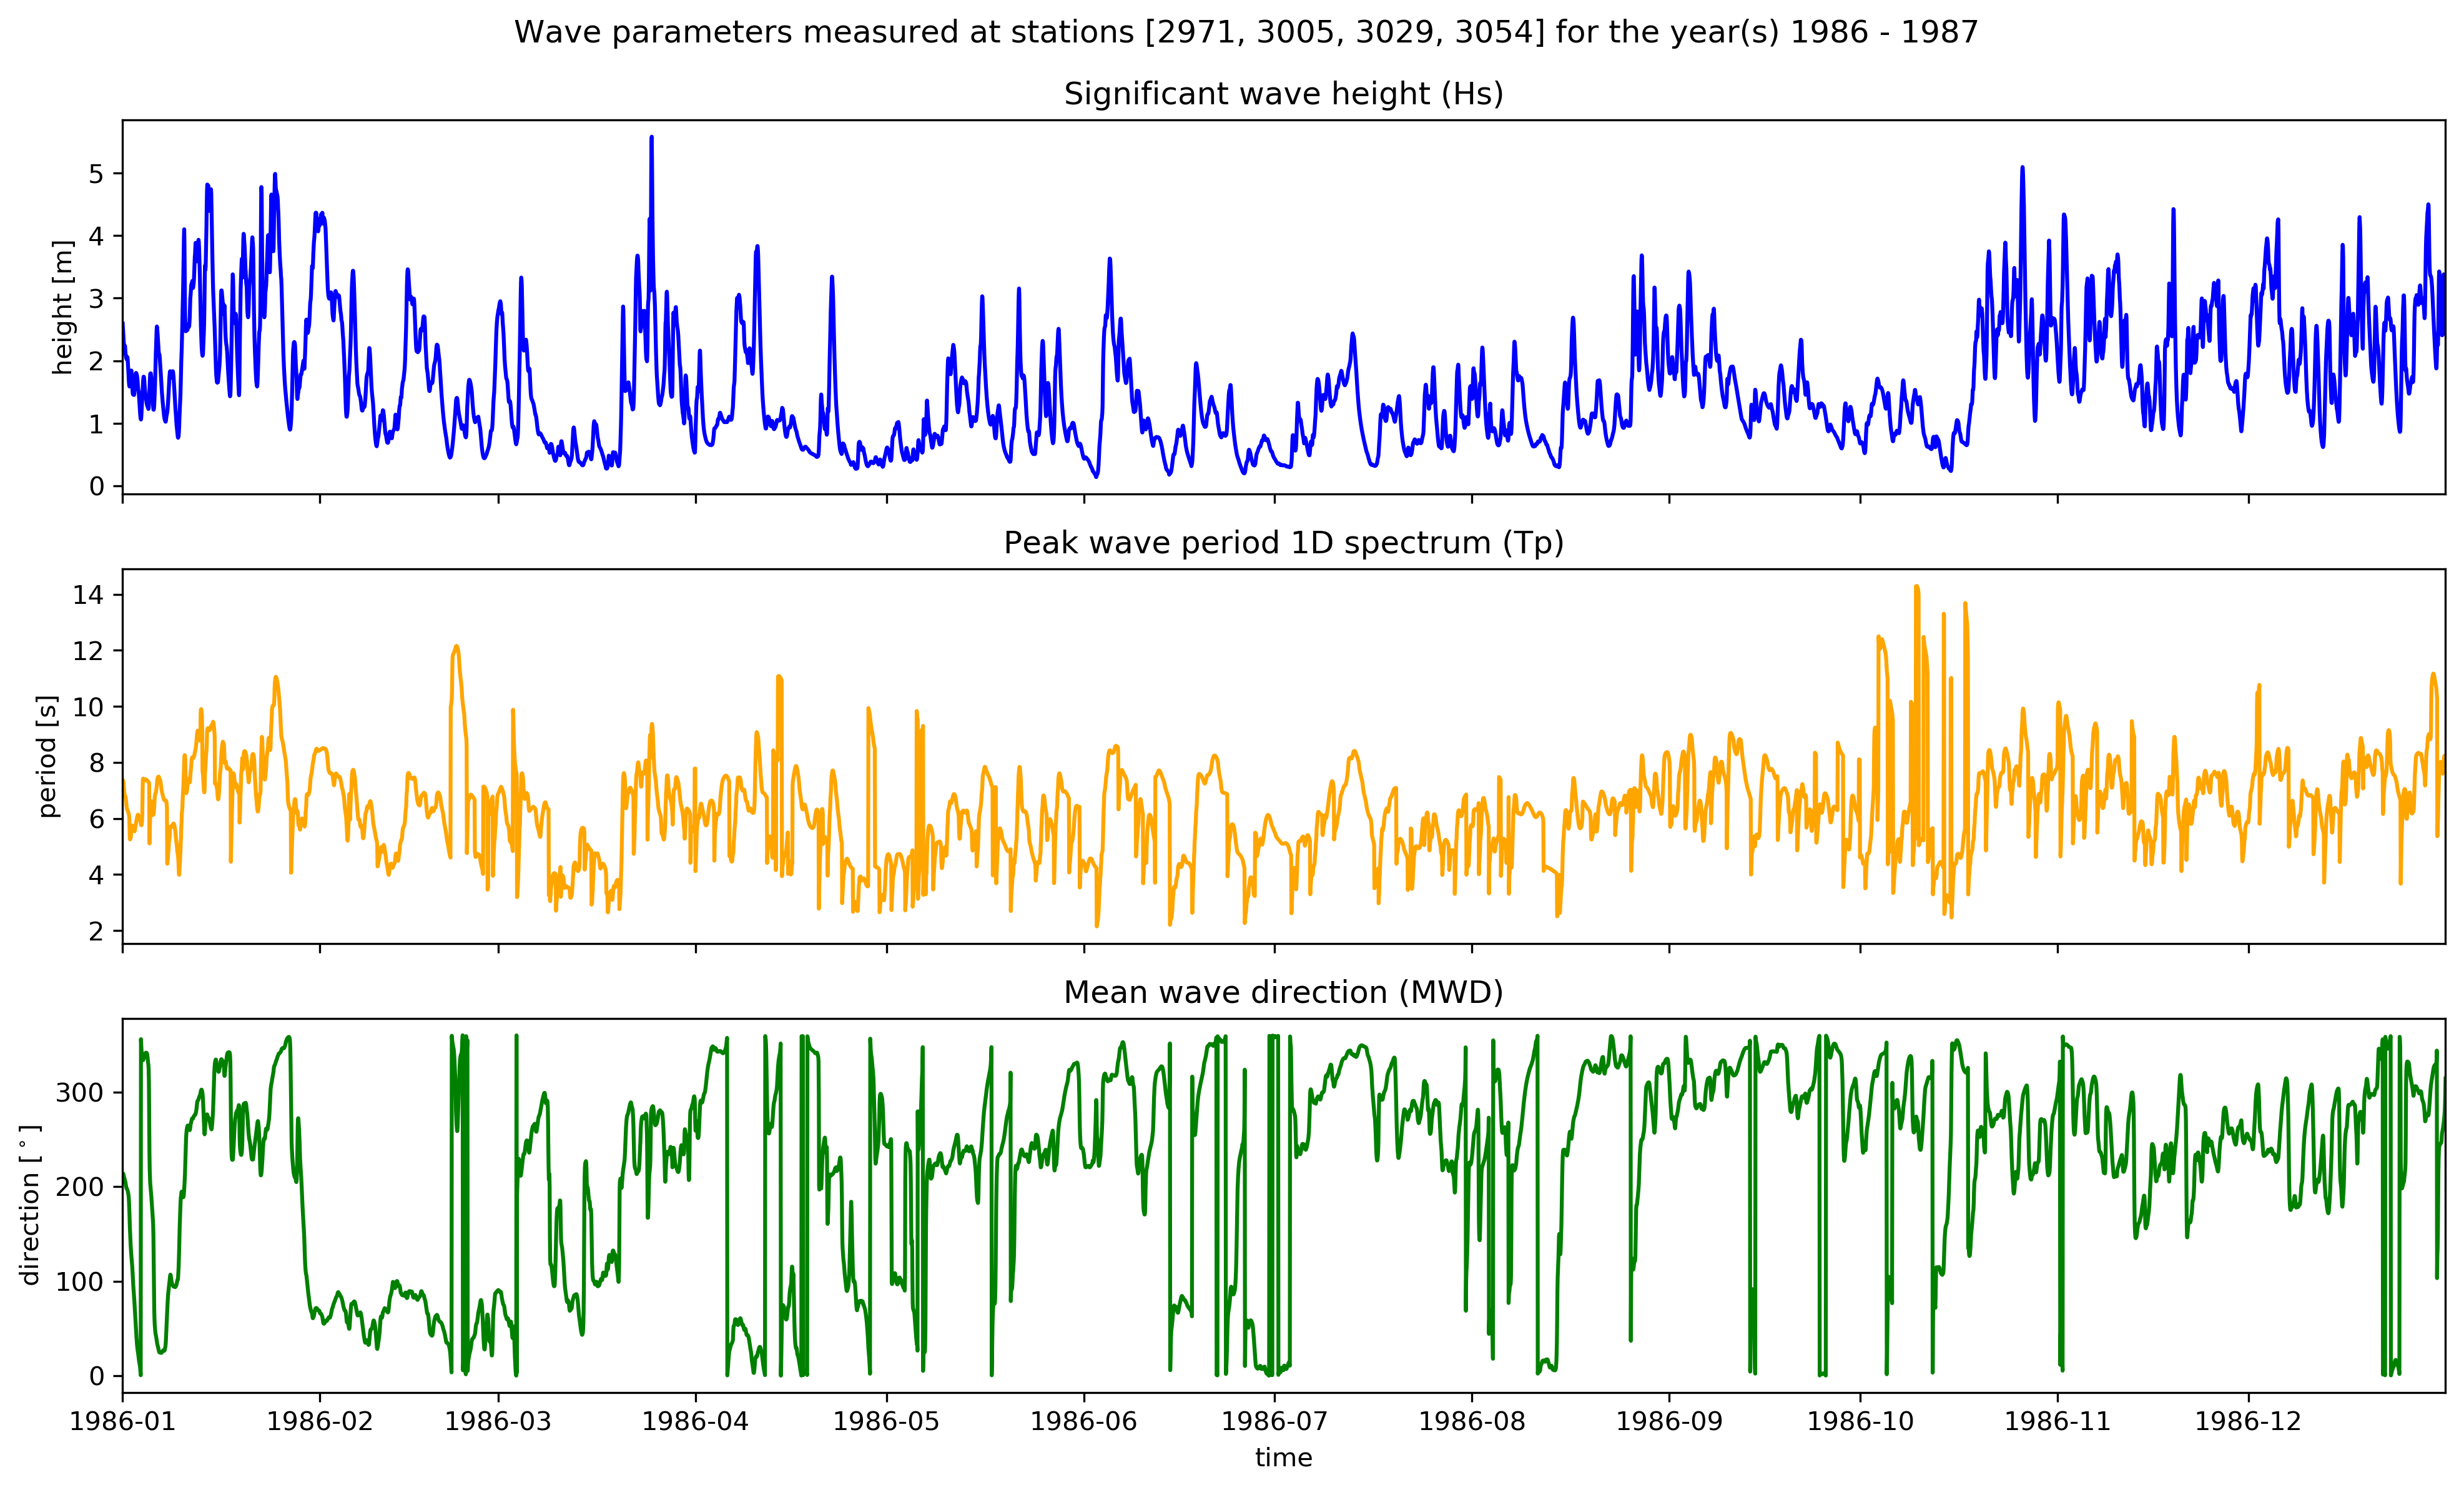

In [7]:
# verification: plot temporal series
sel_stat = 8 # 0-8 determine the location to visualize 
# 19 stations are reduced to 9 as some are on the land (mapped to closest cell in the sea)
# and others overlap as they are too close originally (due to the grid resolution)

# setup the folder where we want to extract data from (created .netcdf files)
folder2 = r'C:\checkouts\trunk\tests\testing_Etienne\datasets'

# open the data in this script to get the info -> from saved NetCDF file
#DS_WAM_ERA5 = Dataset(os.path.join(folder2,'WAM_ERA5_WAVE.nc'))
#time_WAM_ERA5 = list(DS_WAM_ERA5.variables['time'])
#SWH_WAM_ERA5 = list(np.array(DS_WAM_ERA5.variables['SWH']))
#PP1D_WAM_ERA5 = list(np.array(DS_WAM_ERA5.variables['PP1D']))
#MWD_WAM_ERA5 = list(np.array(DS_WAM_ERA5.variables['MWD']))

# direcly from the extracted data stations
stations_idx = Extract_Data_ERA5WAMWAVE.data_dict['stations_idx']
stations = [i for i,val in enumerate(stations_idx) if val==sel_stat]
stations_all = []
for i in stations:
    stations_all.append(station[i])

# direcly from the extracted data variables
time_WAM_ERA5 = list(Extract_Data_ERA5WAMWAVE.data_dict['time'])
SWH_WAM_ERA5 = []
for j in range(len(Extract_Data_ERA5WAMWAVE.data_dict['variables']['swh'][0])):
    substep = []
    for i in Extract_Data_ERA5WAMWAVE.data_dict['variables']['swh']:
        substep.append(i[j])
    SWH_WAM_ERA5.append(np.array(substep))
PP1D_WAM_ERA5 = []
for j in range(len(Extract_Data_ERA5WAMWAVE.data_dict['variables']['pp1d'][0])):
    substep = []
    for i in Extract_Data_ERA5WAMWAVE.data_dict['variables']['pp1d']:
        substep.append(i[j])
    PP1D_WAM_ERA5.append(np.array(substep))
MWD_WAM_ERA5 = []
for j in range(len(Extract_Data_ERA5WAMWAVE.data_dict['variables']['mwd'][0])):
    substep = []
    for i in Extract_Data_ERA5WAMWAVE.data_dict['variables']['mwd']:
        substep.append(i[j])
    MWD_WAM_ERA5.append(np.array(substep))

# rewrite lists to locations
swh_era5 = [[] for i in range(max(stations_idx)+1)]
pp1d_era5 = [[] for i in range(max(stations_idx)+1)]
mwd_era5 = [[] for i in range(max(stations_idx)+1)]
for idx, (i,j,k) in enumerate(zip(SWH_WAM_ERA5, PP1D_WAM_ERA5, MWD_WAM_ERA5)):
    for idv, (l,m,n) in enumerate(zip(i,j,k)):
        swh_era5[idv].append(l)
        pp1d_era5[idv].append(m)
        mwd_era5[idv].append(n)

# time computations
by = timeWAMy[0]
#ly = int(by+round((time_WAM_ERA5[-1]-time_WAM_ERA5[0])/60/60/24/365.2422,2)) # length of the dataset computed timespan in years
ly = int(by+np.ceil(((time_WAM_ERA5[-1]-time_WAM_ERA5[0]).days)/365))

# make a loop per location
fig = plt.figure(figsize=(16, 9), dpi=300, facecolor='white')
if len(stations_all) == 1:
    fig.suptitle('Wave parameters measured at station %s for the year(s) %s - %s'%(stations_all[0], by, ly), y=.94)
else:
    fig.suptitle('Wave parameters measured at stations %s for the year(s) %s - %s'%(stations_all[:], by, ly), y=.94)
    
plt.subplot(3,1,1)
plt.title('Significant wave height (Hs)')
plt.plot(time_WAM_ERA5, swh_era5[sel_stat], 'b-')
plt.ylabel('height [m]')
plt.xlim(time_WAM_ERA5[0], time_WAM_ERA5[-1])
ax1 = plt.gca()
ax1.set_xticklabels([])
    
plt.subplot(3,1,2)
plt.title('Peak wave period 1D spectrum (Tp)')
plt.plot(time_WAM_ERA5, pp1d_era5[sel_stat], '-', color='orange')
plt.ylabel('period [s]')
plt.xlim(time_WAM_ERA5[0], time_WAM_ERA5[-1])
ax2 = plt.gca()
ax2.set_xticklabels([])
    
plt.subplot(3,1,3)
plt.title('Mean wave direction (MWD)')
plt.plot(time_WAM_ERA5, mwd_era5[sel_stat], 'g-')
plt.ylabel('direction [$^\circ$]')
#plt.xlabel('julian time (seconds from 1970-01-01 00:00:00) [s]')
plt.xlabel('time')
plt.xlim(time_WAM_ERA5[0], time_WAM_ERA5[-1])
ax3 = plt.gca()

Task 1b. Extract wave parameters for year 1986 in a gridded box

In [11]:
# select a spatial range (box) for which data is to be extracted
steplon = 0.5 # degrees
lonl = 3 # left lon value
lonr = 7.5 # right lon value
steplat = 0.5 # degrees
latl = 52.5 # lower lat value
latu = 57 # upper lat value
xrange = np.arange(lonl, lonr+steplon, steplon).tolist() 
yrange = np.arange(latl, latu+steplat, steplat).tolist() 

coordsBOXWAVE = {'LON': xrange, 'LAT': yrange}
   
# use the SDToolBox function to create input data
Input_DataBOXWAVE= ind.InputData(
    input_coordinates=coordsBOXWAVE, 
    input_variables=varWAMWAVE, 
    input_scenarios=['era5'],
    input_years=timeWAMy, 
    is_gridded = True)

# use the SDToolBox function to extract data
#print(Input_DataBOXWAVE.input_variables)
#print(Input_DataBOXWAVE.input_coordinates)
Extract_Data_ERA5BOXWAVE = exd.ExtractData.get_era_5(dir_ERA5, Input_DataBOXWAVE)

In [13]:
# get the ERA5 land sea mask
seamask = exd.ExtractData.get_seamask_positions(r'p:\metocean-data\open\ERA5\data\Global\ERA5_landsea_mask.nc')
seapos = seamask[0]
seaLON = seamask[1].flatten()
seaLAT = seamask[2].flatten()

# obtain sea positions list equal to seaLON and seaLAT
seapos_ma = [] # get a list with masked 1's (sea) and zero's (land)
for idx, (i, j) in enumerate(zip(seaLON, seaLAT)):
    print('\r%s'%idx, end="", flush=True)
    if idx in seapos:
        seapos_ma.append(1)
    if idx not in seapos:
        seapos_ma.append(0)
        
# create seamask colormap
cdict = mpl.colors.ListedColormap(['black', 'blue'])

259629

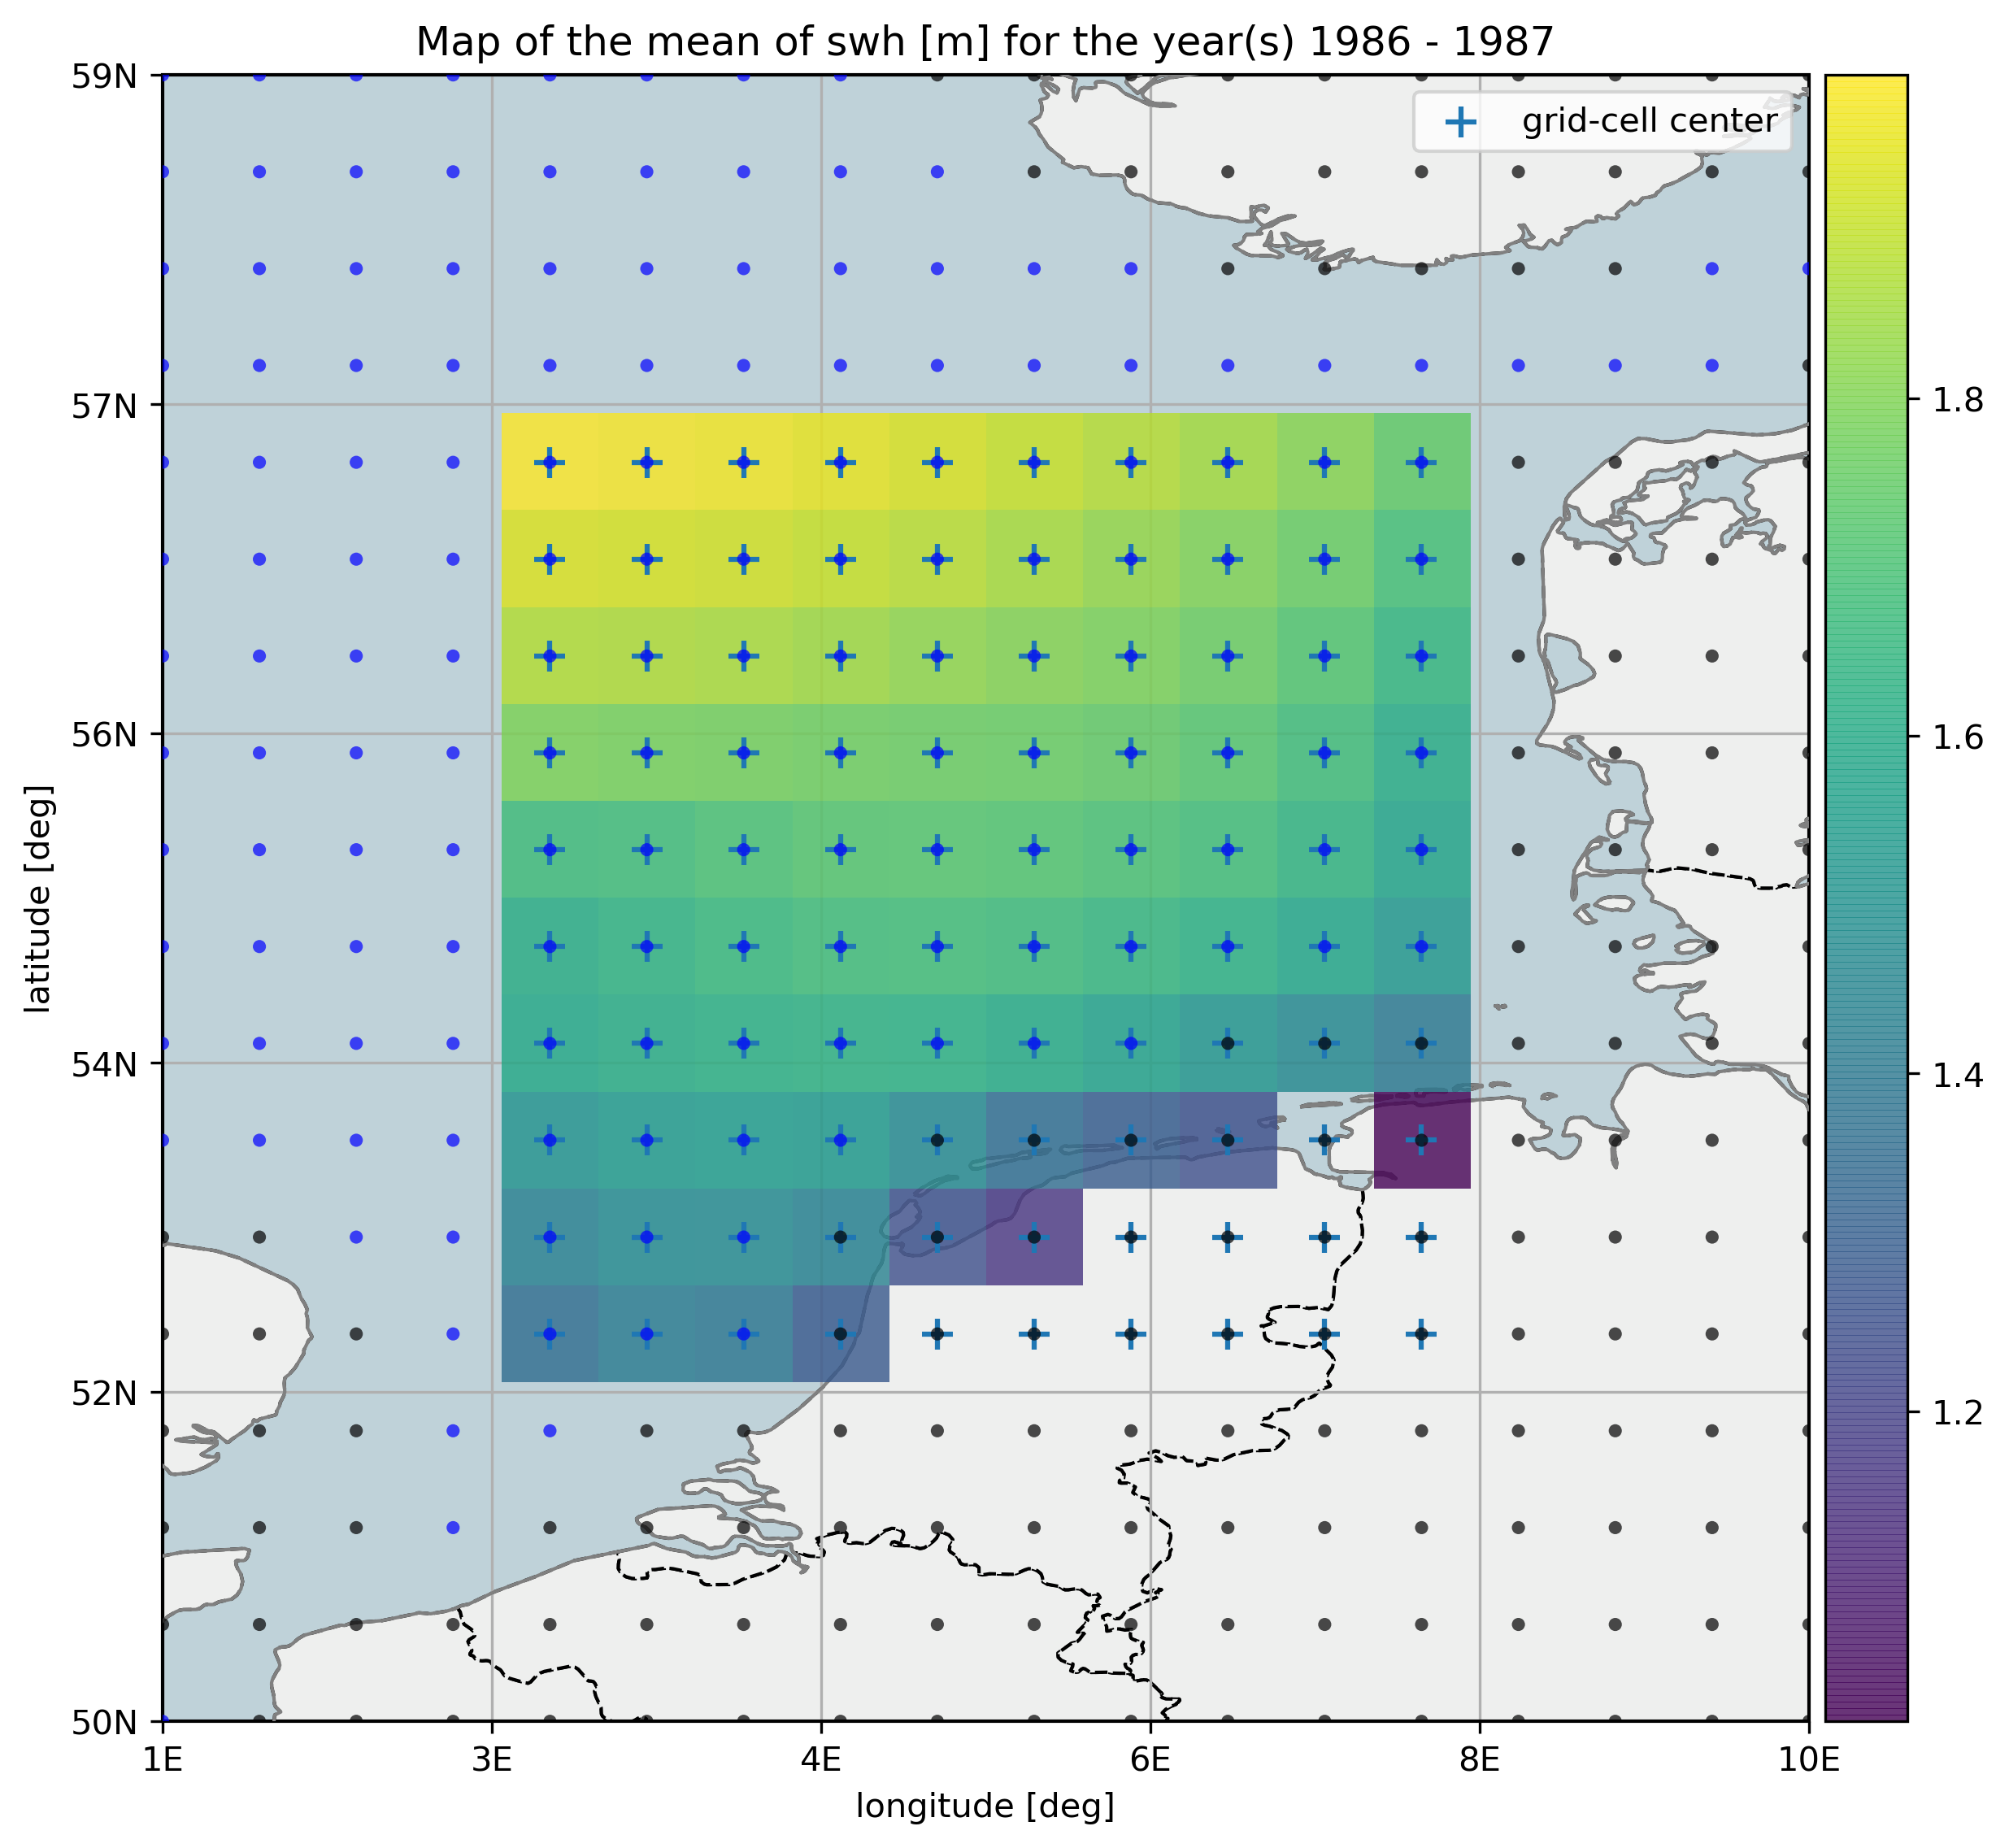

In [19]:
# verification: plot with spatial maps of the mean values and standard deviation for Hs, Tp & MWD

# select variable
sel_variable = 'swh' # either swh, wdw, mp1, pp1d or mwd
sel_type = 'mean' # either mean or std
for idx, i in enumerate(Input_DataBOXWAVE.input_variables):
    if i == sel_variable:
        sel_var = idx

# re-work data
step_grd = Input_DataBOXWAVE.input_coordinates['LON'][1]-Input_DataBOXWAVE.input_coordinates['LON'][0]
if sel_type == 'mean':
    plotvar = Extract_Data_ERA5BOXWAVE.data_dict['variables'][Input_DataBOXWAVE.input_variables[sel_var]].mean(axis=0)
    plotvar[plotvar==-3.27670000e+04]=np.nan
if sel_type == 'std':
    plotvar = Extract_Data_ERA5BOXWAVE.data_dict['variables'][Input_DataBOXWAVE.input_variables[sel_var]].std(axis=0)
    plotvar[plotvar==0.]=np.nan   

# make plot
fig = plt.figure(figsize=(16, 9), dpi=300, facecolor='white')

# world map
ax = plt.axes([0, 0.12, 0.83, 0.75],projection=cartopy.crs.PlateCarree())
ax.grid()

_ = ax.set_xlim(min(Input_DataBOXWAVE.input_coordinates['LON'])-2, max(Input_DataBOXWAVE.input_coordinates['LON'])+2)                 
_ = ax.set_ylim(min(Input_DataBOXWAVE.input_coordinates['LAT'])-2, max(Input_DataBOXWAVE.input_coordinates['LAT'])+2) 
_ = ax.set_xticks(np.linspace(min(Input_DataBOXWAVE.input_coordinates['LON'])-2, max(Input_DataBOXWAVE.input_coordinates['LON'])+2, num=6), crs=cartopy.crs.PlateCarree()) 
_ = ax.set_yticks(np.linspace(min(Input_DataBOXWAVE.input_coordinates['LAT'])-2, max(Input_DataBOXWAVE.input_coordinates['LAT'])+2, num=6), crs=cartopy.crs.PlateCarree()) 

# Set RGB value to ocean colour '#bfd2d9' has 191, G:210, B:217 as 10m ocean cartopy import gives errors
ax.imshow(np.tile(np.array([[[191, 210, 217]]], dtype=np.uint8), [2, 2, 1]), origin='upper', transform=cartopy.crs.PlateCarree(), extent=[-180, 180, -180, 180])

# load features, add features and add axes
country_10m = cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m')
ax.add_feature(country_10m, edgecolor='k', linestyle='--', facecolor='#EEEFEE')
ax.coastlines(resolution='10m', color='grey', zorder=5);

lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='',
                                   dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# plot the data
plotcoordx, plotcoordy = np.meshgrid(Input_DataBOXWAVE.input_coordinates['LON'], Input_DataBOXWAVE.input_coordinates['LAT'])
ax.scatter(plotcoordx.flatten(),plotcoordy.flatten(), zorder=13,alpha=1,s=80, marker='+', transform=cartopy.crs.PlateCarree(), label='grid-cell center');
plot = ax.imshow(plotvar, alpha=0.8, zorder = 11, extent=(Input_DataBOXWAVE.input_coordinates['LON'][0]-step_grd/2, Input_DataBOXWAVE.input_coordinates['LON'][-1]+step_grd/2, Input_DataBOXWAVE.input_coordinates['LAT'][0]-step_grd/2, Input_DataBOXWAVE.input_coordinates['LAT'][-1]+step_grd/2))
fig.colorbar(plot, pad=0.005)
if Input_DataBOXWAVE.input_variables[sel_var] == 'swh':
    if sel_type == 'mean':
        plt.title('Map of the mean of %s [m] for the year(s) %s - %s'%(Input_DataBOXWAVE.input_variables[sel_var], by, ly))
    if sel_type == 'std':
        plt.title('Map of the std of %s [m] for the year(s) %s - %s'%(Input_DataBOXWAVE.input_variables[sel_var], by, ly))
if Input_DataBOXWAVE.input_variables[sel_var] == 'pp1d':
    if sel_type == 'mean':
        plt.title('Map of the mean of %s [s] for the year(s) %s - %s'%(Input_DataBOXWAVE.input_variables[sel_var], by, ly))
    if sel_type == 'std':
        plt.title('Map of the std of %s [s] for the year(s) %s - %s'%(Input_DataBOXWAVE.input_variables[sel_var], by, ly))  
if Input_DataBOXWAVE.input_variables[sel_var] == 'mwd':
    if sel_type == 'mean':
        plt.title('Map of the mean of %s [degree] for the year(s) %s - %s'%(Input_DataBOXWAVE.input_variables[sel_var], by, ly))
    if sel_type == 'std':
        plt.title('Map of the std of %s [degree] for the year(s) %s - %s'%(Input_DataBOXWAVE.input_variables[sel_var], by, ly))         
plt.scatter(seaLON, seaLAT, c=seapos_ma, cmap=cdict, s=15, linewidths=0, zorder=14, alpha=0.7)
plt.ylabel('latitude [deg]')
plt.xlabel('longitude [deg]')
plt.legend();

Task 2. Extract mean sea level pressure from ERA5 dataset on a gridded box on the North Sea

In [20]:
# select a spatial range (box) for which data is to be extracted
steplon = 0.25 # degrees
lonl = 3 # left lon value
lonr = 7.5 # right lon value
steplat = 0.25 # degrees
latl = 52.5 # lower lat value
latu = 57 # upper lat value
xrange = np.arange(lonl, lonr+steplon, steplon).tolist() 
yrange = np.arange(latl, latu+steplat, steplat).tolist() 

coordsBOXMSL = {'LON': xrange, 'LAT': yrange}
    
# use the SDToolBox function to create input data
Input_DataBOXMSL = ind.InputData(
    input_coordinates=coordsBOXMSL, 
    input_variables=['msl'], 
    input_scenarios=['era5'],
    input_years=timeWAMy, 
    is_gridded = True)

# use the SDToolBox function to extract data
#print(Input_DataBOXMSL.input_variables)
#print(Input_DataBOXMSL.input_coordinates)
Extract_Data_ERA5BOXMSL = exd.ExtractData.get_era_5(dir_ERA5, Input_DataBOXMSL)

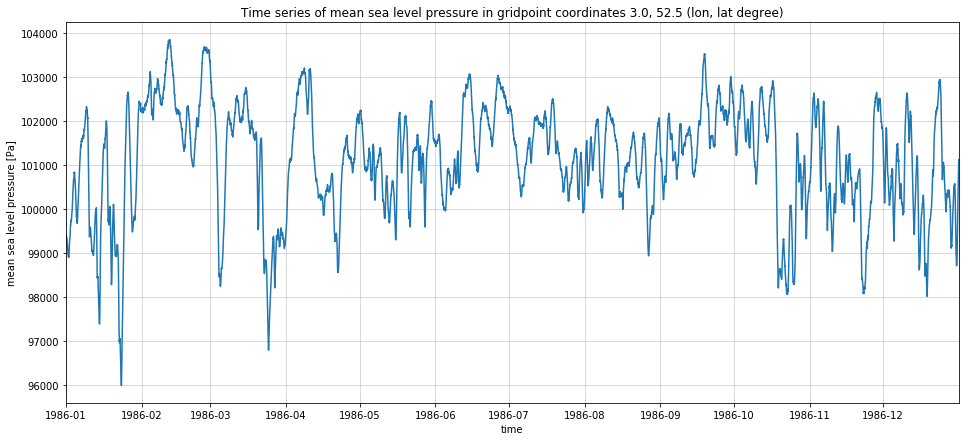

In [23]:
# verification: plot temporal series of a point in the grid
select_gridx = 0 # the x grid point
select_gridy = 0 # the y grid point
temp_mslp = []
for i in Extract_Data_ERA5BOXMSL.data_dict['variables']['msl']:
    temp_mslp.append(i[select_gridx][select_gridy])
    
plt.figure(figsize=(16,7))
plt.plot(Extract_Data_ERA5BOXMSL.data_dict['time'], temp_mslp)
plt.grid(alpha=0.6)
plt.xlim(Extract_Data_ERA5BOXMSL.data_dict['time'][0], Extract_Data_ERA5BOXMSL.data_dict['time'][-1])
plt.title('Time series of mean sea level pressure in gridpoint coordinates %s, %s (lon, lat degree)'%(Input_DataBOXMSL.input_coordinates['LON'][select_gridx*2], Input_DataBOXMSL.input_coordinates['LAT'][select_gridy*2]));
plt.xlabel('time')
plt.ylabel('mean sea level pressure [Pa]');

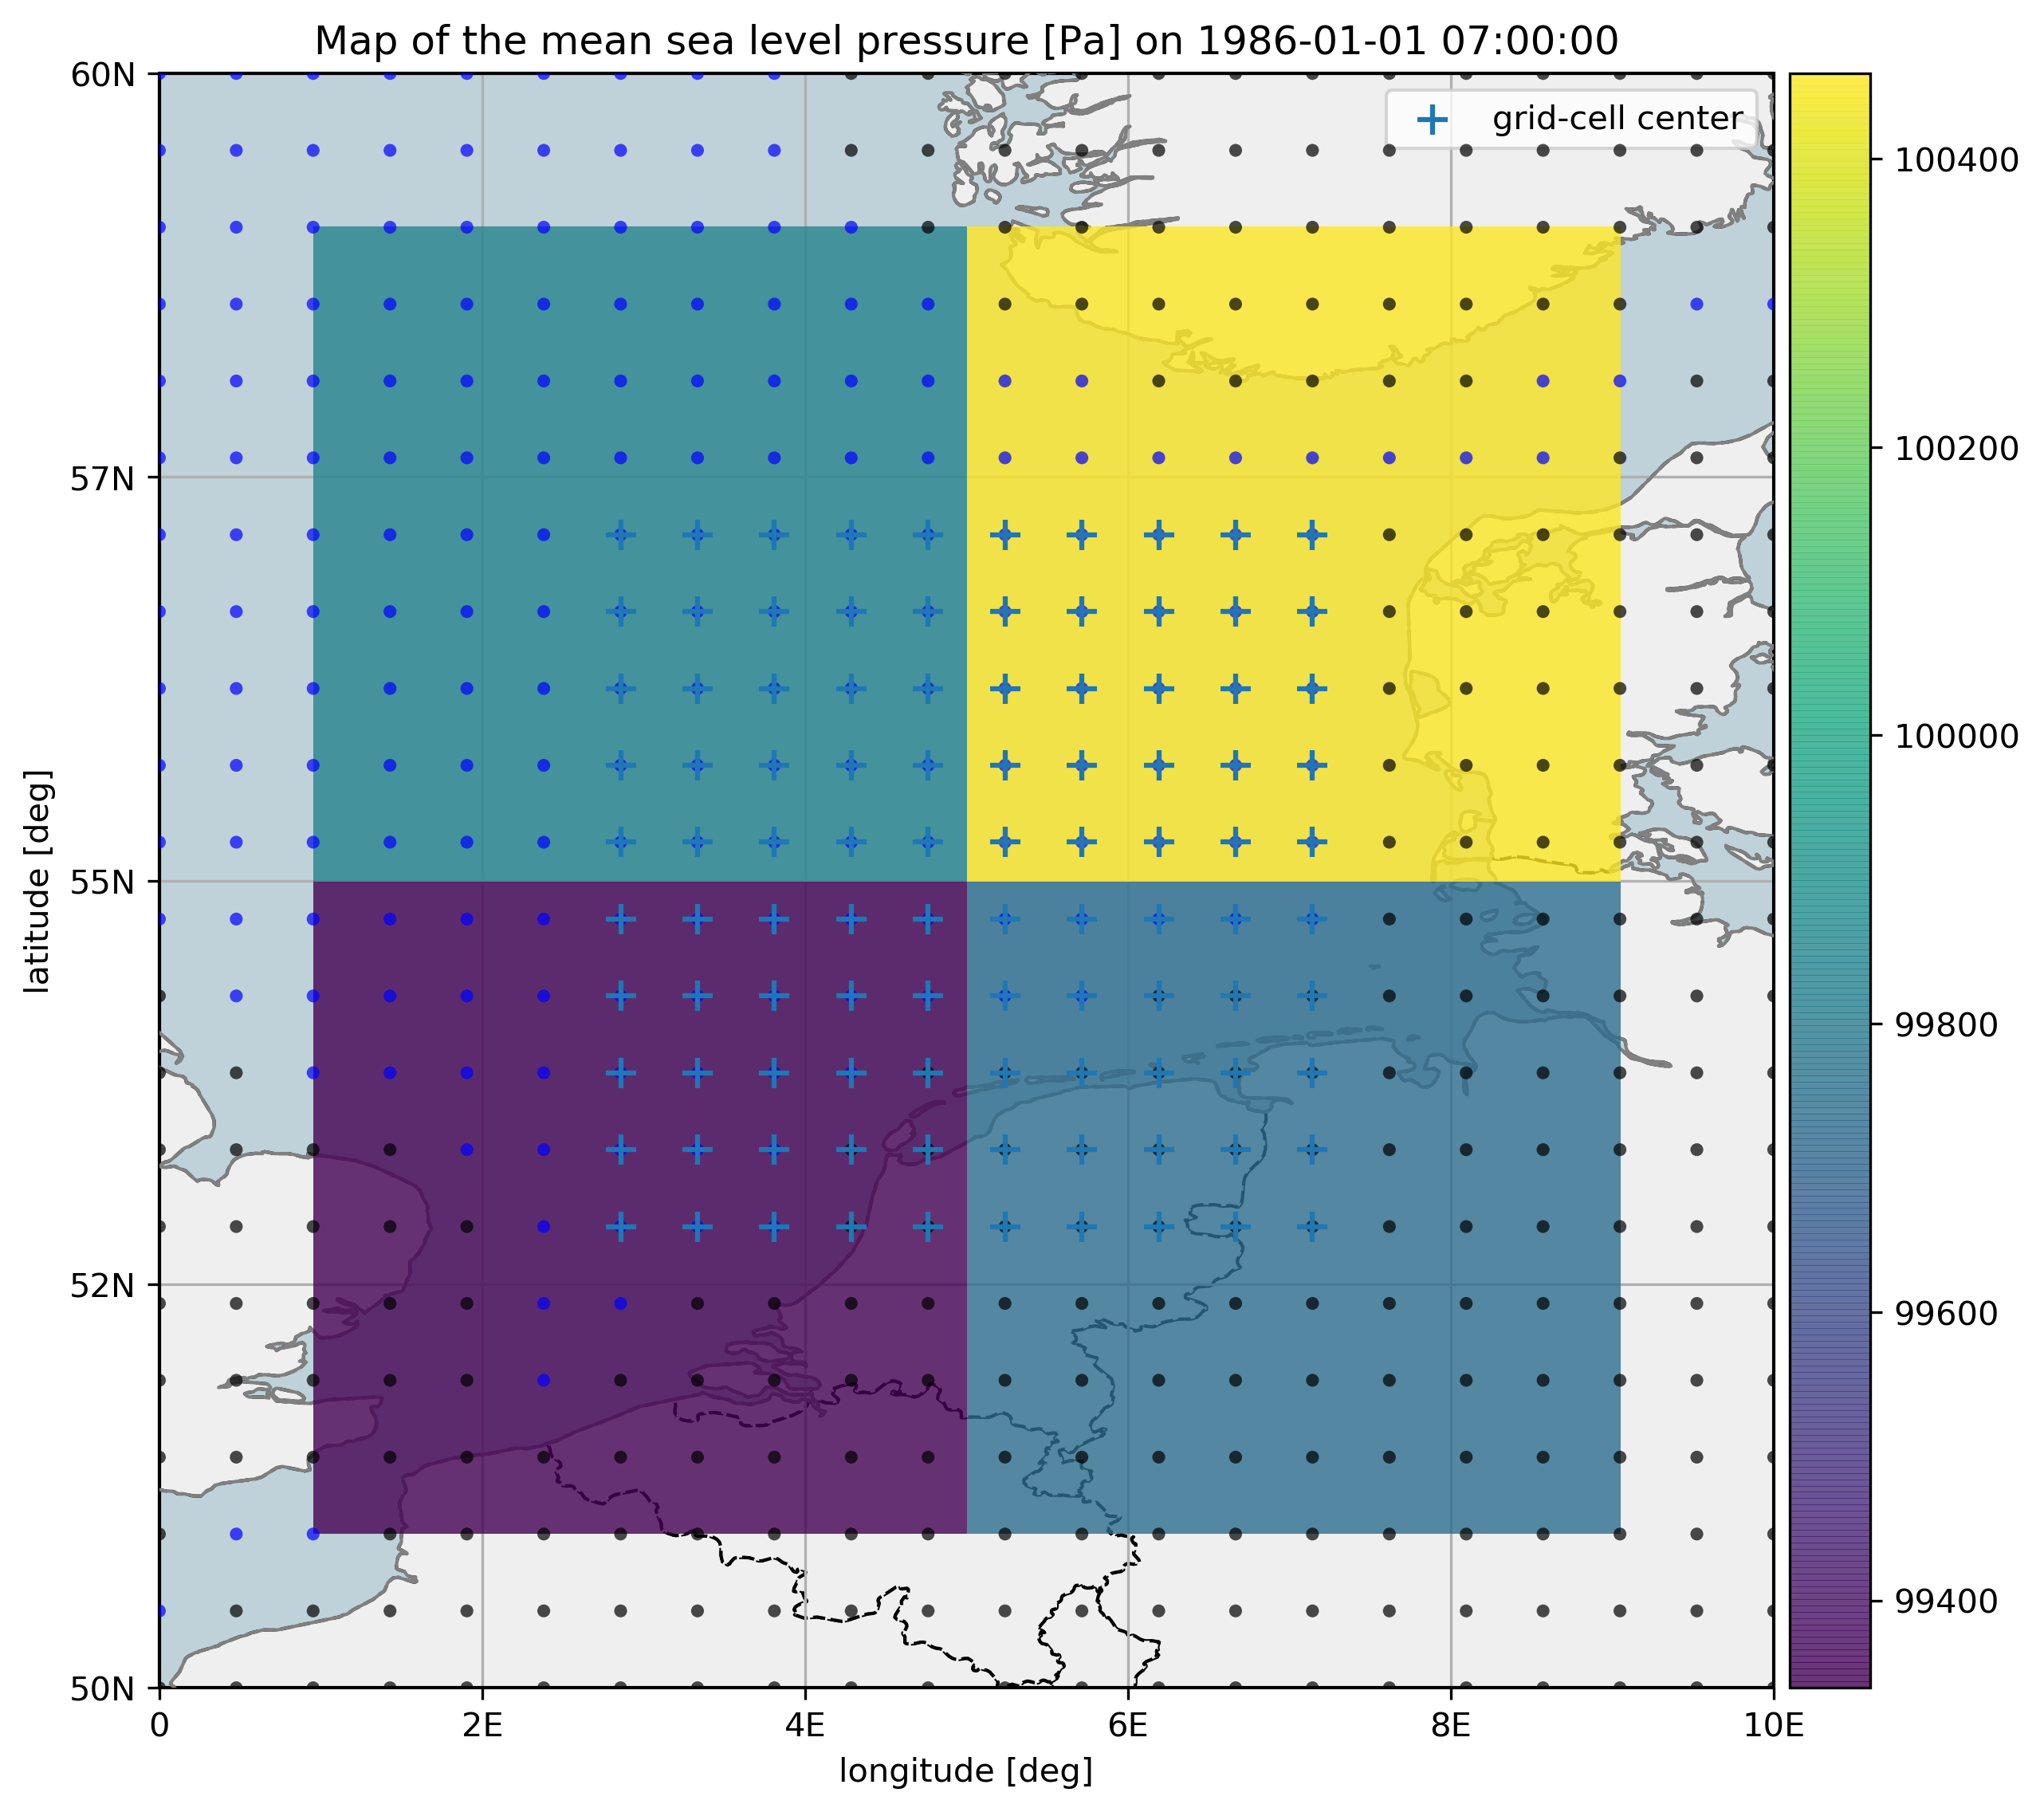

In [24]:
# verficiation: plot spatial map of the mean sea level pressure
# select timestep
sel_time = 7

# make plot
fig = plt.figure(figsize=(16, 9), dpi=300, facecolor='white')

# world map
ax = plt.axes([0, 0.12, 0.83, 0.75],projection=cartopy.crs.PlateCarree())
ax.grid()

_ = ax.set_xlim(min(Input_DataBOXMSL.input_coordinates['LON'][0::2])-3, max(Input_DataBOXMSL.input_coordinates['LON'][0::2])+3)                 
_ = ax.set_ylim(min(Input_DataBOXMSL.input_coordinates['LAT'][0::2])-3, max(Input_DataBOXMSL.input_coordinates['LAT'][0::2])+3) 
_ = ax.set_xticks(np.linspace(min(Input_DataBOXMSL.input_coordinates['LON'][0::2])-3, max(Input_DataBOXMSL.input_coordinates['LON'][0::2])+3, num=6), crs=cartopy.crs.PlateCarree()) 
_ = ax.set_yticks(np.linspace(min(Input_DataBOXMSL.input_coordinates['LAT'][0::2])-3, max(Input_DataBOXMSL.input_coordinates['LAT'][0::2])+3, num=5), crs=cartopy.crs.PlateCarree()) 

# Set RGB value to ocean colour '#bfd2d9' has 191, G:210, B:217 as 10m ocean cartopy import gives errors
ax.imshow(np.tile(np.array([[[191, 210, 217]]], dtype=np.uint8), [2, 2, 1]), origin='upper', transform=cartopy.crs.PlateCarree(), extent=[-180, 180, -180, 180])

# load features, add features and add axes
country_10m = cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m')
ax.add_feature(country_10m, edgecolor='k', linestyle='--', facecolor='#EEEFEE')
ax.coastlines(resolution='10m', color='grey', zorder=5);

lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='',
                                   dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# plot the data
plotcoordx, plotcoordy = np.meshgrid(Input_DataBOXMSL.input_coordinates['LON'][0::2], Input_DataBOXMSL.input_coordinates['LAT'][::2])
ax.scatter(plotcoordx.flatten(),plotcoordy.flatten(), zorder=14,alpha=1,s=80, marker='+', transform=cartopy.crs.PlateCarree(), label='grid-cell center');
plot = ax.imshow(Extract_Data_ERA5BOXMSL.data_dict['variables']['msl'][sel_time], alpha=0.8, zorder = 12, extent=(Input_DataBOXMSL.input_coordinates['LON'][0::2][0]-2, Input_DataBOXMSL.input_coordinates['LON'][0::2][-1]+2, Input_DataBOXMSL.input_coordinates['LAT'][0::2][0]-2, Input_DataBOXMSL.input_coordinates['LAT'][0::2][-1]+2))
fig.colorbar(plot, pad=0.005)
plt.scatter(seaLON, seaLAT, c=seapos_ma, cmap=cdict, s=15, linewidths=0, zorder=13, alpha=0.7)
plt.title('Map of the mean sea level pressure [Pa] on %s'%(Extract_Data_ERA5BOXMSL.data_dict['time'][sel_time]));
plt.ylabel('latitude [deg]')
plt.xlabel('longitude [deg]')
plt.legend();

Task 3. Test functionality to generate output netcdf files for waves and sealevel pressure

In [26]:
# generate output data for waves -> array (task 1a)
ERA5WAMWAVE = oud.OutputData.generate_output(
    Extract_Data_ERA5WAMWAVE,
    dir_path=r'C:\checkouts\trunk\tests\testing_Etienne\datasets',
    base_name='WAM',
    dataset_code='ERA5_WAVE') # .netcdf saved to directory, xarray left here

# generate output data for waves -> gridded (task 1b) 
ERA5BOXWAVE = oud.OutputData.generate_output(
    Extract_Data_ERA5BOXWAVE,
    dir_path=r'C:\checkouts\trunk\tests\testing_Etienne\datasets',
    base_name='BOX',
    dataset_code='ERA5_WAVE') # .netcdf saved to directory, xarray left here

# generate output data for sealevel pressure -> gridded (task 2) 
ERA5BOXMSL = oud.OutputData.generate_output(
    Extract_Data_ERA5BOXMSL,
    dir_path=r'C:\checkouts\trunk\tests\testing_Etienne\datasets',
    base_name='BOX',
    dataset_code='ERA5_MSL') # .netcdf saved to directory, xarray left here

# 2. Data Preprocessing

Make use of the following functions:
5. predictor_definition (pde)

Task 4. Compute the squared spatial gradients of mean sea level pressure

In [27]:
# continue with xarray data structure or load netCDF data and make an xarray 

#MSLP
# continue xarray.Dataset 8760 time
#print(ERA5BOXMSL)
#print()

# load xarray.Dataset 8760 time
empty_output = oud.OutputData(None)
ERA5BOXMSL_load = empty_output.generate_xarray_from_netcdf(os.path.join(r'C:\checkouts\trunk\tests\testing_Etienne\datasets','BOX_ERA5_MSL.nc'))
#print(ERA5BOXMSL_load)
#print()

# load manually chunked gridded dataset with time = 1000 -> FAILS (contains longitude and latitude instead of lon and lat)
empty_output = oud.OutputData(None)
ERA5BOXMSL_check = empty_output.generate_xarray_from_netcdf(os.path.join(r'C:\checkouts\trunk\tests\testing_Etienne\chunked_data','era5_Global_msl_p_1986.nc'))
#print(ERA5BOXMSL_check)
#print()

# write chunk to lon and lat to correct the failing dataset
ERA5BOXMSL_chunk = Dataset(os.path.join(r'C:\checkouts\trunk\tests\testing_Etienne\chunked_data','era5_Global_msl_p_1986.nc'))
ERA5BOXMSL_check2 = xr.DataArray( # resampling 1000 timesteps takes very long -> moved to 10
    ERA5BOXMSL_chunk['msl'][0:10,:,:],
    coords=[ERA5BOXMSL_chunk['time'][0:10], ERA5BOXMSL_chunk['longitude'][:], ERA5BOXMSL_chunk['latitude'][:]],
    dims=['time', 'lon', 'lat'])
ERA5BOXMSL_check3 = xr.Dataset(
    {
        'MSL': (
            ('time', 'lat', 'lon'),
            ERA5BOXMSL_chunk['msl'][:,:,:]),        
    },
    coords = {
        'time':pd.date_range('01/01/1986',periods=len(ERA5BOXMSL_chunk['time'][:]),freq=pd.DateOffset(hours=1)),
        'lat': ERA5BOXMSL_chunk['latitude'][:],
        'lon': ERA5BOXMSL_chunk['longitude'][:]})  
#print(ERA5BOXMSL_check2)
#print()

#WAVE
# continue xarray.Dataset 8760 time
#print(ERA5BOXWAVE)
#print()

# load xarray.Dataset 8760 time
empty_output = oud.OutputData(None)
ERA5BOXWAVE_load = empty_output.generate_xarray_from_netcdf(os.path.join(r'C:\checkouts\trunk\tests\testing_Etienne\datasets','BOX_ERA5_WAVE.nc'))
#print(ERA5BOXWAVE_load)
#print()

# load manually chunked gridded dataset with time = 1000 -> FAILS (contains longitude and latitude instead of lon and lat)
empty_output = oud.OutputData(None)
ERA5BOXWAVE_check = empty_output.generate_xarray_from_netcdf(os.path.join(r'C:\checkouts\trunk\tests\testing_Etienne\chunked_data','era5_Global_Hs_1986.nc'))
#print(ERA5BOXWAVE_check)
#print()

# write chunk to lon and lat to correct the failing dataset
ERA5BOXWAVE_chunk = Dataset(os.path.join(r'C:\checkouts\trunk\tests\testing_Etienne\chunked_data','era5_Global_Hs_1986.nc'))
ERA5BOXWAVE_check2 = xr.DataArray( # resampling 1000 timesteps takes very long -> moved to 10
    ERA5BOXWAVE_chunk['swh'][0:10,:,:],
    coords=[ERA5BOXWAVE_chunk['time'][0:10:], ERA5BOXWAVE_chunk['longitude'][:], ERA5BOXWAVE_chunk['latitude'][:]],
    dims=['time', 'lon', 'lat'])
ERA5BOXWAVE_check3 = xr.Dataset( 
    {
        'swh': (
            ('time', 'lat', 'lon'),
            ERA5BOXWAVE_chunk['swh'][:,:,:]),        
    },
    coords = {
        'time':pd.date_range('01/01/1986',periods=len(ERA5BOXWAVE_chunk['time'][:]),freq=pd.DateOffset(hours=1)),
        'lat': ERA5BOXWAVE_chunk['latitude'][:],
        'lon': ERA5BOXWAVE_chunk['longitude'][:]})   
#print(ERA5BOXWAVE_check2)
#print()

ERROR:root:List of variable names should be given.
ERROR:root:List of variable names should be given.
ERROR:root:List of variable names should be given.
ERROR:root:List of variable names should be given.


In [28]:
# spatial gradient computation
spatgrad_resultMSLP = pde.PredictorDefinition.compute_spatial_gradients(data_array = ERA5BOXMSL_check2)

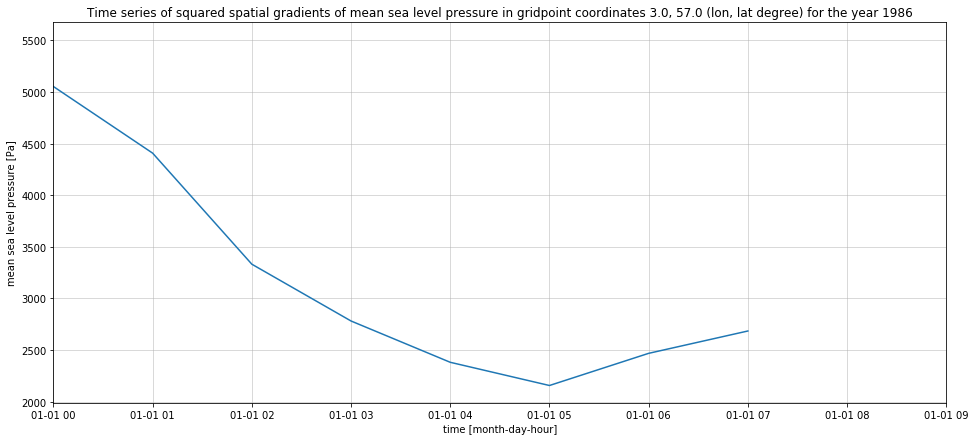

In [30]:
# verification: for a point in the grid plot temporal series

select_gridx = 0 # the x grid point
select_gridy = 0 # the y grid point
temp_csg = []
for i in spatgrad_resultMSLP:
    temp_csg.append(i[select_gridx][select_gridy])
    
# correct time
time_csg = []
for i in ERA5BOXMSL_check2['time'][0:10]:
    time_csg.append(datetime(1900, 1, 1) + timedelta(hours=int(i)))
    
plt.figure(figsize=(16,7))
plt.plot(time_csg, temp_csg)
plt.grid(alpha=0.6)
plt.xlim(time_csg[0], time_csg[-1])
plt.title('Time series of squared spatial gradients of mean sea level pressure in gridpoint coordinates %s, %s (lon, lat degree) for the year %s'%(ERA5BOXMSL_check2['lon'][:][select_gridx].values, ERA5BOXMSL_check2['lat'][:][select_gridy].values, str(time_csg[0])[0:4]));
plt.ylabel('mean sea level pressure [Pa]')
plt.xlabel('time [month-day-hour]');

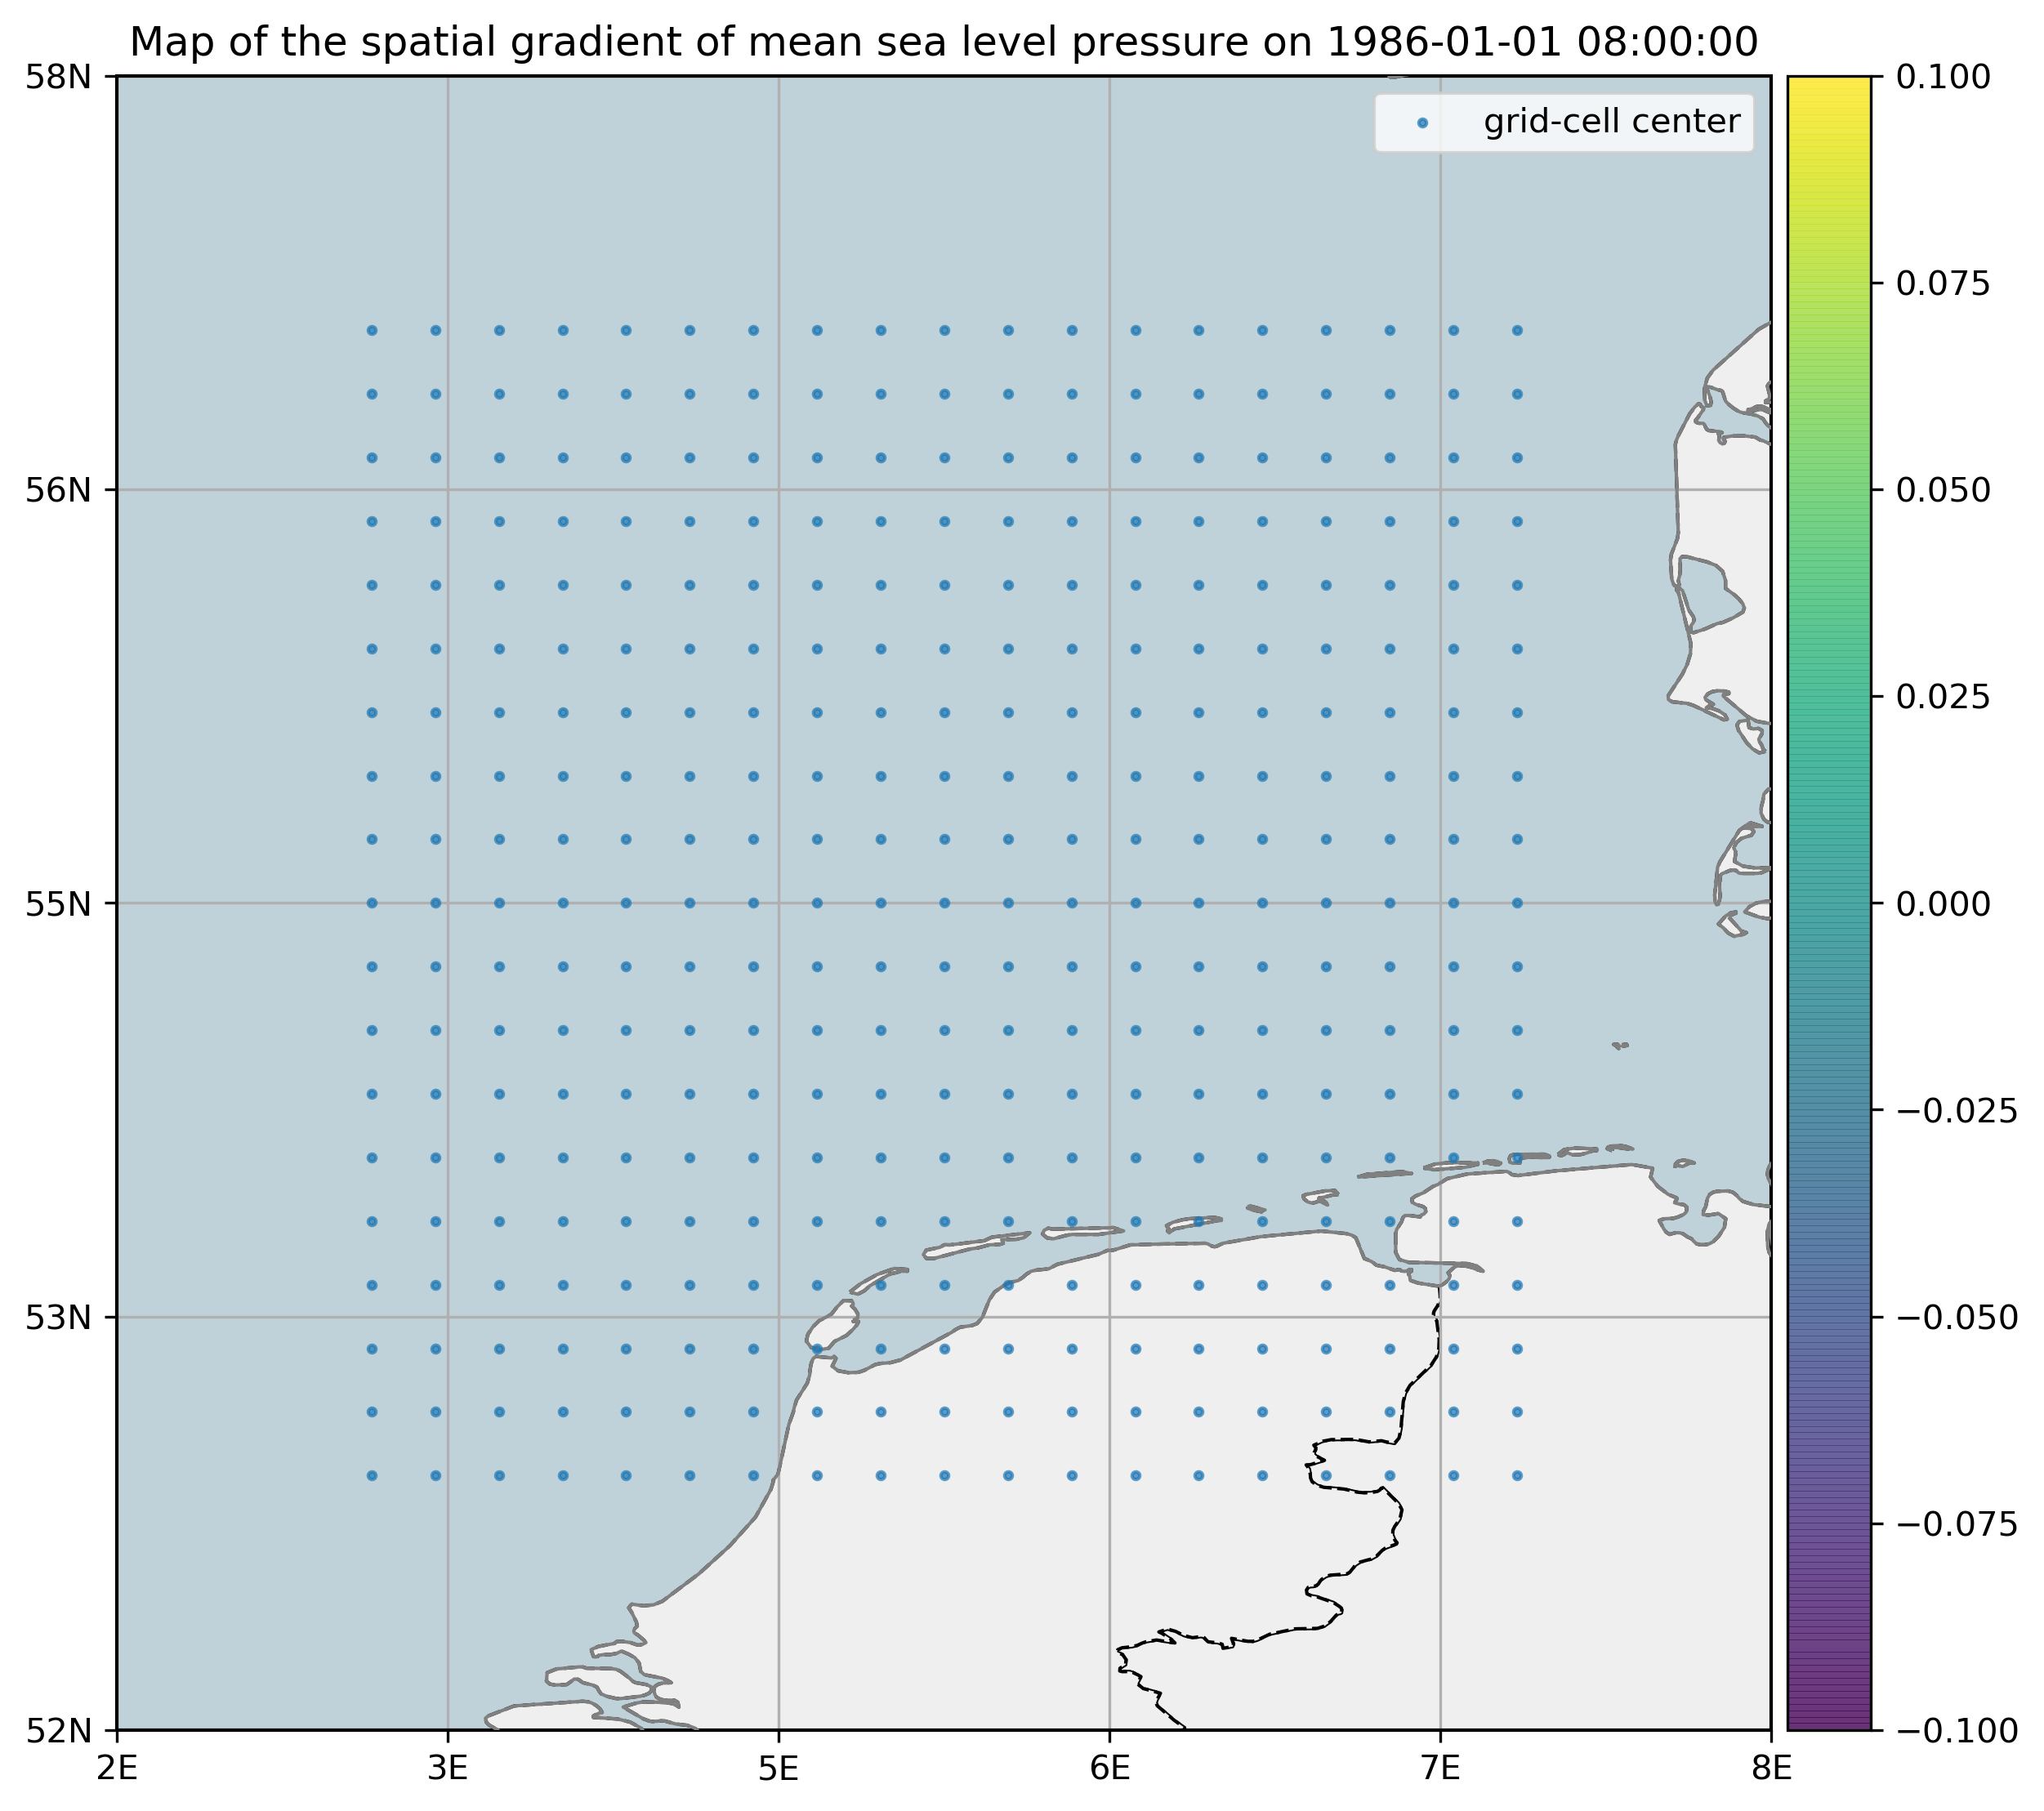

In [38]:
# verification: spatial map of the spatial gradient of mean sea level pressure 

# select timestep
sel_time = 8 # between 0-9 for this example

# make plot
fig = plt.figure(figsize=(16, 9), dpi=300, facecolor='white')

# world map
ax = plt.axes([0, 0.12, 0.83, 0.75],projection=cartopy.crs.PlateCarree())
ax.grid()

_ = ax.set_xlim(min(ERA5BOXMSL_chunk['longitude'][:])-1, max(ERA5BOXMSL_chunk['longitude'][:])+1)                 
_ = ax.set_ylim(min(ERA5BOXMSL_chunk['latitude'][:])-1, max(ERA5BOXMSL_chunk['latitude'][:])+1) 
_ = ax.set_xticks(np.linspace(min(ERA5BOXMSL_chunk['longitude'][:])-1, max(ERA5BOXMSL_chunk['longitude'][:])+1, num=6), crs=cartopy.crs.PlateCarree()) 
_ = ax.set_yticks(np.linspace(min(ERA5BOXMSL_chunk['latitude'])-1, max(ERA5BOXMSL_chunk['latitude'])+1, num=5), crs=cartopy.crs.PlateCarree()) 

# Set RGB value to ocean colour '#bfd2d9' has 191, G:210, B:217 as 10m ocean cartopy import gives errors
ax.imshow(np.tile(np.array([[[191, 210, 217]]], dtype=np.uint8), [2, 2, 1]), origin='upper', transform=cartopy.crs.PlateCarree(), extent=[-180, 180, -180, 180])

# load features, add features and add axes
country_10m = cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m')
ax.add_feature(country_10m, edgecolor='k', linestyle='--', facecolor='#EEEFEE')
ax.coastlines(resolution='10m', color='grey', zorder=5);

lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='',
                                   dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# plot the data
plotcoordx, plotcoordy = np.meshgrid(ERA5BOXMSL_chunk['longitude'][:].tolist(), ERA5BOXMSL_chunk['latitude'][:].tolist())
ax.scatter(plotcoordx.flatten(),plotcoordy.flatten(), zorder=13,alpha=0.7,s=5, transform=cartopy.crs.PlateCarree(), label='grid-cell center');
plot = ax.imshow(spatgrad_resultMSLP[sel_time], alpha=0.8, zorder = 12, extent=(ERA5BOXMSL_chunk['longitude'][:][0]-0.125, ERA5BOXMSL_chunk['longitude'][:][-1]+0.125, ERA5BOXMSL_chunk['latitude'][:][0]+0.125, ERA5BOXMSL_chunk['latitude'][:][-1]-0.125))
fig.colorbar(plot, pad=0.005)
#plt.title('Map of the spatial gradient of mean sea level pressure on %s'%(round(HS_chunk['time'][0]/24/365.2422,2)+1900));
plt.title('Map of the spatial gradient of mean sea level pressure on %s'%((datetime(1900, 1, 1) + timedelta(hours=int(ERA5BOXMSL_chunk['time'][sel_time])))));
plt.legend();

Task 5. Temporal resampling

In [32]:
# wave climate data: hourly to 3 hourly
resampled_resultWAVE = dap.DataProcessing.mean_time_resampling(dataset = ERA5BOXWAVE, 
                                                               scale = 0,
                                                               frequency_string = '3H')

# mean sea level pressure: hourly to 6hourly 
resampled_resultMSLP = dap.DataProcessing.mean_time_resampling(dataset = ERA5BOXMSL_check, 
                                                               scale = 0,
                                                               frequency_string = '6H')

# create a dataset with gradients of MSLP
ERA5BOXGMSL = xr.Dataset(
    {
        'MSL': (
            ('time', 'lat', 'lon'),
            spatgrad_resultMSLP),
    },
    coords={
        'time': pd.date_range('01/01/1986',periods=10,freq=pd.DateOffset(hours=1)),
        'lat': ERA5BOXMSL_check['latitude'][:].values,
        'lon': ERA5BOXMSL_check['longitude'][:].values})
#ERA5BOXGMSL.attrs['cdm_data_type'] = True

# mean sea level pressure gradient: hourly to 6hourly
resampled_resultGMSLP = dap.DataProcessing.mean_time_resampling(dataset = ERA5BOXGMSL, 
                                                                scale = 0,
                                                                frequency_string = '6H')

c:\users\kras\anaconda3\envs\sdtoolbox_env\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


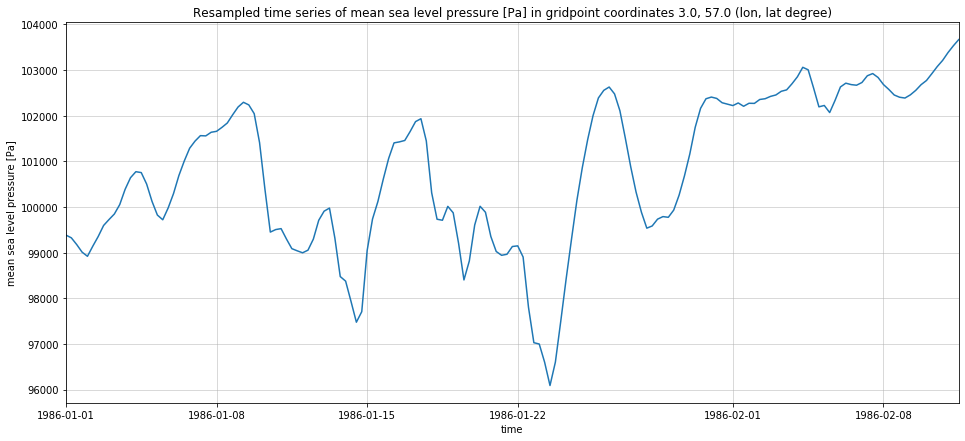

In [33]:
# verification: for a point in the grid plot temporal series
plot_data = 'mslp' # either wave_swh, wave_tp, wave_mwd, mslp or gmslp

select_gridx = 0 # the x grid point
select_gridy = 0 # the y grid point
temp_resamWAVE_SWH = [] # 3h
temp_resamWAVE_TP = []  # 3h
temp_resamWAVE_MWD = [] # 3h
temp_resamMSLP = [] # 6h
temp_resamGMSLP = [] # 6h
timesWAVE = resampled_resultWAVE.indexes['time']
timesMSLP = resampled_resultMSLP.indexes['time']
timesGMSLP = resampled_resultGMSLP.indexes['time']
for i in resampled_resultWAVE['SWH']:
    temp_resamWAVE_SWH.append(float(i[select_gridx][select_gridy].values))
for i in resampled_resultWAVE['PP1D']:
    temp_resamWAVE_TP.append(float(i[select_gridx][select_gridy].values))
for i in resampled_resultWAVE['MWD']:
    temp_resamWAVE_MWD.append(float(i[select_gridx][select_gridy].values))
for i in resampled_resultMSLP['msl']:
    temp_resamMSLP.append(float(i[select_gridx][select_gridy].values))
for i in resampled_resultGMSLP['MSL']:
    temp_resamGMSLP.append(float(i[select_gridx][select_gridy].values))

plt.figure(figsize=(16,7))
plt.grid(alpha=0.6)
plt.xlabel('time')
if plot_data == 'wave_swh':
    plt.plot(timesWAVE, temp_resamWAVE_SWH)
    plt.xlim(timesWAVE.tolist()[0], timesWAVE.tolist()[-1])
    plt.title('Resampled time series of swh [m] in gridpoint coordinates %s, %s (lon, lat degree)'%(Input_DataBOXWAVE.input_coordinates['LON'][select_gridx], Input_DataBOXWAVE.input_coordinates['LAT'][select_gridy]));
    plt.ylabel('wave height [m]')
if plot_data == 'wave_tp':
    plt.plot(timesWAVE, temp_resamWAVE_TP)
    plt.xlim(timesWAVE.tolist()[0], timesWAVE.tolist()[-1])
    plt.title('Resampled time series of pp1d [s] in gridpoint coordinates %s, %s (lon, lat degree)'%(Input_DataBOXWAVE.input_coordinates['LON'][select_gridx], Input_DataBOXWAVE.input_coordinates['LAT'][select_gridy]));
    plt.ylabel('peak wave period [s]')
if plot_data == 'wave_mwd':
    plt.plot(timesWAVE, temp_resamWAVE_MWD)
    plt.xlim(timesWAVE.tolist()[0], timesWAVE.tolist()[-1])
    plt.title('Resampled time series of mwd [degree] in gridpoint coordinates %s, %s (lon, lat degree)'%(Input_DataBOXWAVE.input_coordinates['LON'][select_gridx], Input_DataBOXWAVE.input_coordinates['LAT'][select_gridy]));
    plt.ylabel('mean wave direction [degree]')
if plot_data == 'mslp': 
    plt.plot(timesMSLP, temp_resamMSLP)
    plt.xlim(timesMSLP.tolist()[0], timesMSLP.tolist()[-1])
    plt.title('Resampled time series of mean sea level pressure [Pa] in gridpoint coordinates %s, %s (lon, lat degree)'%(ERA5BOXMSL_check2['lon'][:][select_gridx].values, ERA5BOXMSL_check2['lat'][:][select_gridy].values));
    plt.ylabel('mean sea level pressure [Pa]')
if plot_data == 'gmslp':
    plt.plot(timesGMSLP, temp_resamGMSLP)
    plt.xlim(timesGMSLP.tolist()[0], timesGMSLP.tolist()[-1])
    plt.title('Resampled time series of mean sea level pressure in gridpoint coordinates %s, %s (lon, lat degree)'%(ERA5BOXMSL_check2['lon'][:][select_gridx].values, ERA5BOXMSL_check2['lat'][:][select_gridy].values));
    plt.ylabel('mean sea level pressure [Pa]')

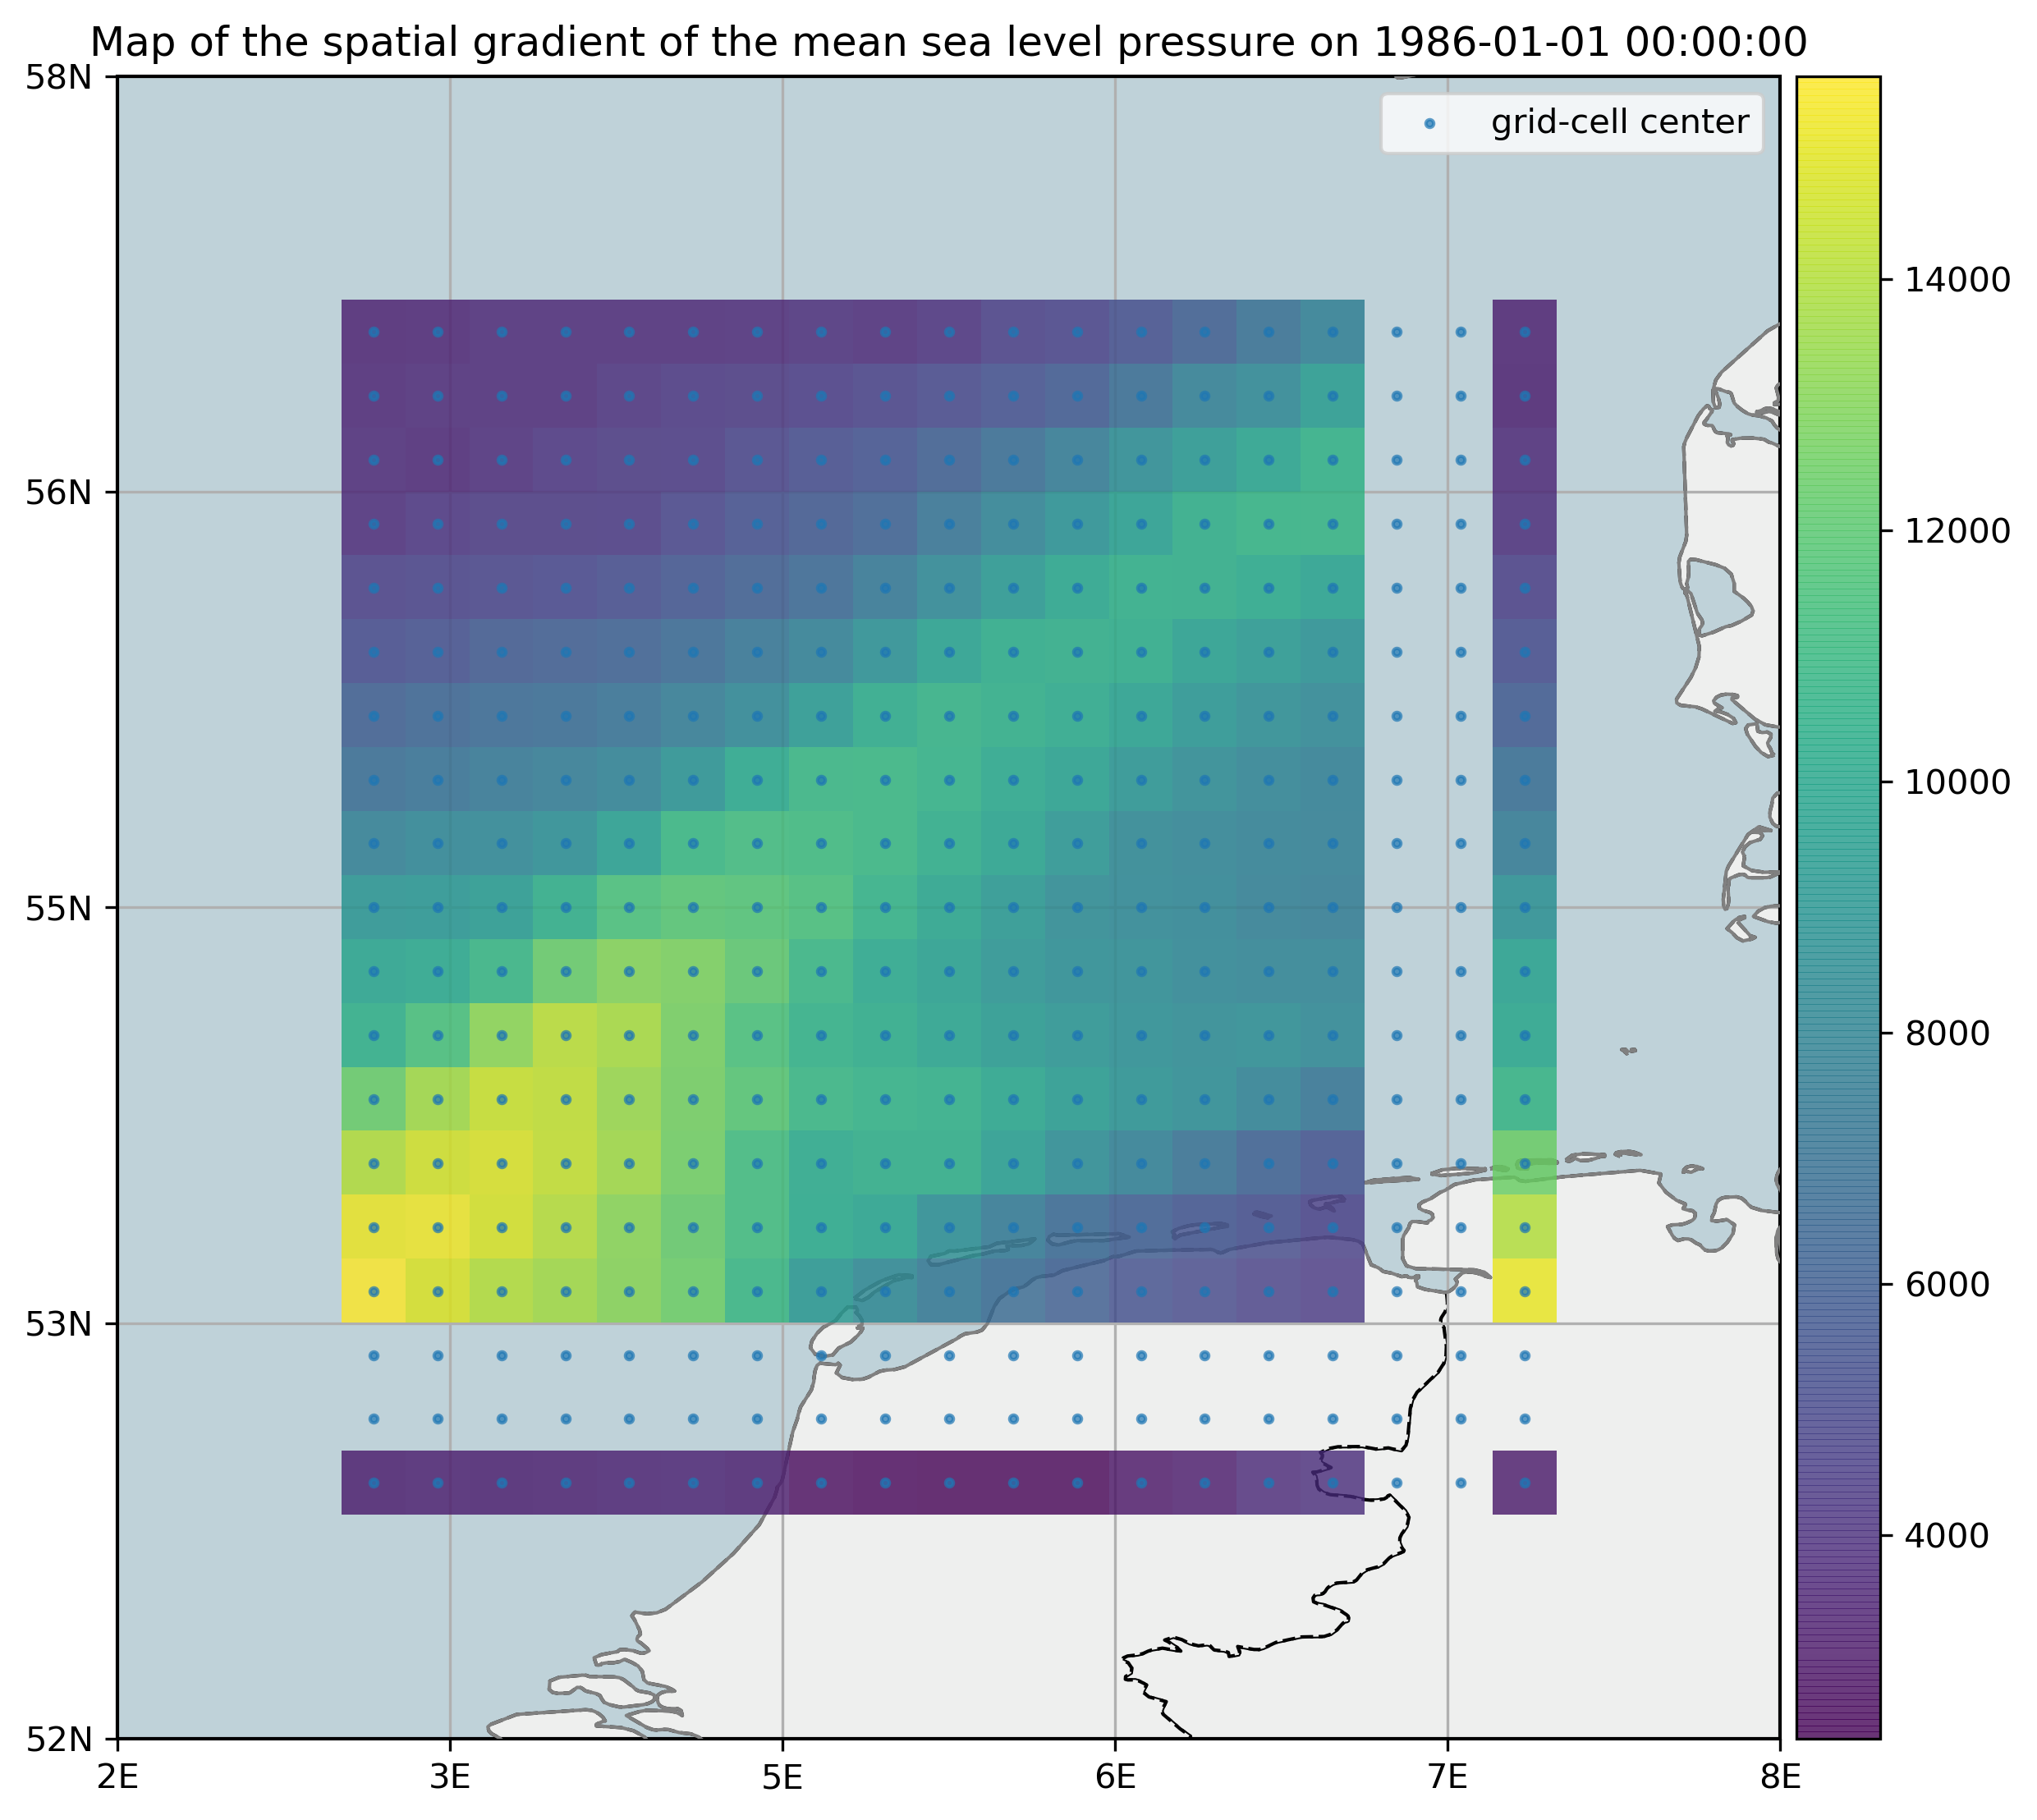

In [34]:
# verification: spatial map of the mean sea level pressure and gradient

sel_type = 'gradient' # either pressure or gradient
sel_time = 0 # between 0-1 for gradient and 0-166 for pressure

if sel_type == 'pressure':
    dataplot = resampled_resultMSLP
if sel_type == 'gradient':
    dataplot = resampled_resultGMSLP

# make plot
fig = plt.figure(figsize=(16, 9), dpi=300, facecolor='white')

# world map
ax = plt.axes([0, 0.12, 0.83, 0.75],projection=cartopy.crs.PlateCarree())
ax.grid()

if sel_type == 'pressure':
    _ = ax.set_xlim(min(dataplot['longitude'][:])-1, max(dataplot['longitude'][:])+1)                 
    _ = ax.set_ylim(min(dataplot['latitude'][:])-1, max(dataplot['latitude'][:])+1) 
    _ = ax.set_xticks(np.linspace(min(dataplot['longitude'][:])-1, max(dataplot['longitude'][:])+1, num=6), crs=cartopy.crs.PlateCarree()) 
    _ = ax.set_yticks(np.linspace(min(dataplot['latitude'])-1, max(dataplot['latitude'])+1, num=5), crs=cartopy.crs.PlateCarree()) 
if sel_type == 'gradient':
    _ = ax.set_xlim(min(dataplot['lon'][:])-1, max(dataplot['lon'][:])+1)                 
    _ = ax.set_ylim(min(dataplot['lat'][:])-1, max(dataplot['lat'][:])+1) 
    _ = ax.set_xticks(np.linspace(min(dataplot['lon'][:])-1, max(dataplot['lon'][:])+1, num=6), crs=cartopy.crs.PlateCarree()) 
    _ = ax.set_yticks(np.linspace(min(dataplot['lat'])-1, max(dataplot['lat'])+1, num=5), crs=cartopy.crs.PlateCarree()) 
    
# Set RGB value to ocean colour '#bfd2d9' has 191, G:210, B:217 as 10m ocean cartopy import gives errors
ax.imshow(np.tile(np.array([[[191, 210, 217]]], dtype=np.uint8), [2, 2, 1]), origin='upper', transform=cartopy.crs.PlateCarree(), extent=[-180, 180, -180, 180])

# load features, add features and add axes
country_10m = cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m')
ax.add_feature(country_10m, edgecolor='k', linestyle='--', facecolor='#EEEFEE')
ax.coastlines(resolution='10m', color='grey', zorder=5);

lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='',
                                   dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# plot the data
if sel_type == 'pressure':
    plotcoordx, plotcoordy = np.meshgrid(dataplot['longitude'][:], dataplot['latitude'][:])
    ax.scatter(plotcoordx.flatten(),plotcoordy.flatten(), zorder=13,alpha=0.7,s=5, transform=cartopy.crs.PlateCarree(), label='grid-cell center');
    plot = ax.imshow(dataplot['msl'][sel_time].values, alpha=0.8, zorder = 12, extent=(dataplot['longitude'].values[0]-0.125, dataplot['longitude'].values[-1]+0.125, dataplot['latitude'].values[0]+0.125, dataplot['latitude'].values[-1]-0.125))
    plt.title('Map of the mean sea level pressure on %s'%(dataplot['time'][sel_time].values));
if sel_type == 'gradient':
    plotcoordx, plotcoordy = np.meshgrid(dataplot['lon'][:], dataplot['lat'][:])
    ax.scatter(plotcoordx.flatten(),plotcoordy.flatten(), zorder=13,alpha=0.7,s=5, transform=cartopy.crs.PlateCarree(), label='grid-cell center');
    plot = ax.imshow(dataplot['MSL'][sel_time].values, alpha=0.8, zorder = 12, extent=(dataplot['lon'].values[0]-0.125, dataplot['lon'].values[-1]+0.125, dataplot['lat'].values[0]+0.125, dataplot['lat'].values[-1]-0.125))
    plt.title('Map of the spatial gradient of the mean sea level pressure on %s %s'%(str(dataplot['time'][sel_time].values)[0:10], str(dataplot['time'][sel_time].values)[11:19]));
fig.colorbar(plot, pad=0.005)
plt.legend();

Task 6. Spatial resampling

In [35]:
# mean sea level pressure 0.5 degree to 1 degree
spat_resampled_resultMSLP = dap.DataProcessing.spatial_resampling(dataset = ERA5BOXMSL_check3, 
                                                                  resolution = 4)
spat_resampled_resultGMSLP = dap.DataProcessing.spatial_resampling(dataset = ERA5BOXGMSL, 
                                                                  resolution = 4)

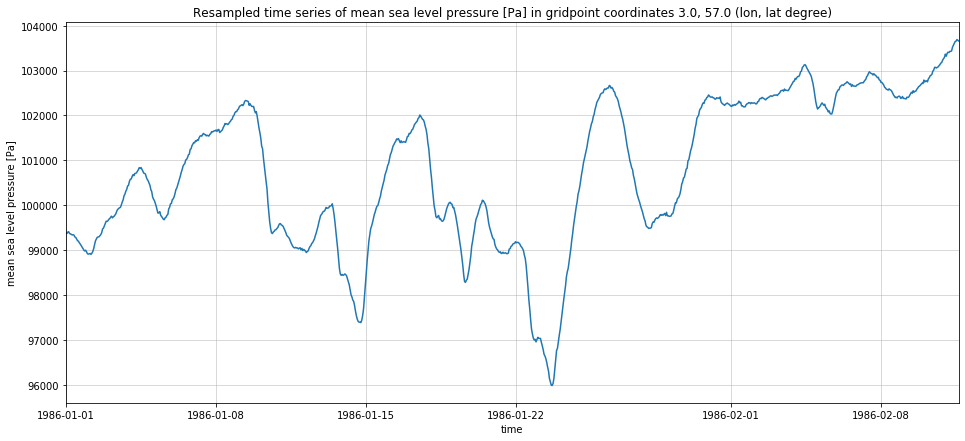

In [36]:
# verification: for a point in the grid plot temporal series
plot_data = 'mslp' # either mslp or gmslp 

select_gridx = 0 # the x grid point
select_gridy = 0 # the y grid point
spat_resamMSLP = [] 
spat_resamGMSLP = []
timesMSLP = spat_resampled_resultMSLP.indexes['time']
timesGMSLP = spat_resampled_resultGMSLP.indexes['time']
for i in spat_resampled_resultMSLP['MSL']:
    spat_resamMSLP.append(float(i[select_gridx][select_gridy].values))
for i in spat_resampled_resultGMSLP['MSL']:
    spat_resamGMSLP.append(float(i[select_gridx][select_gridy].values))

plt.figure(figsize=(16,7))
plt.grid(alpha=0.6)
plt.xlabel('time')
if plot_data == 'mslp': 
    plt.plot(timesMSLP, spat_resamMSLP)
    plt.xlim(timesMSLP.tolist()[0], timesMSLP.tolist()[-1])
    plt.title('Resampled time series of mean sea level pressure [Pa] in gridpoint coordinates %s, %s (lon, lat degree)'%(ERA5BOXMSL_check2['lon'][:][select_gridx].values, ERA5BOXMSL_check2['lat'][:][select_gridy].values));
    plt.ylabel('mean sea level pressure [Pa]')
if plot_data == 'gmslp': 
    plt.plot(timesGMSLP, spat_resamGMSLP)
    plt.xlim(timesGMSLP.tolist()[0], timesGMSLP.tolist()[-1])
    plt.title('Resampled time series of mean sea level pressure gradient [Pa] in gridpoint coordinates %s, %s (lon, lat degree)'%(ERA5BOXMSL_check2['lon'][:][select_gridx].values, ERA5BOXMSL_check2['lat'][:][select_gridy].values));
    plt.ylabel('mean sea level pressure [Pa]')

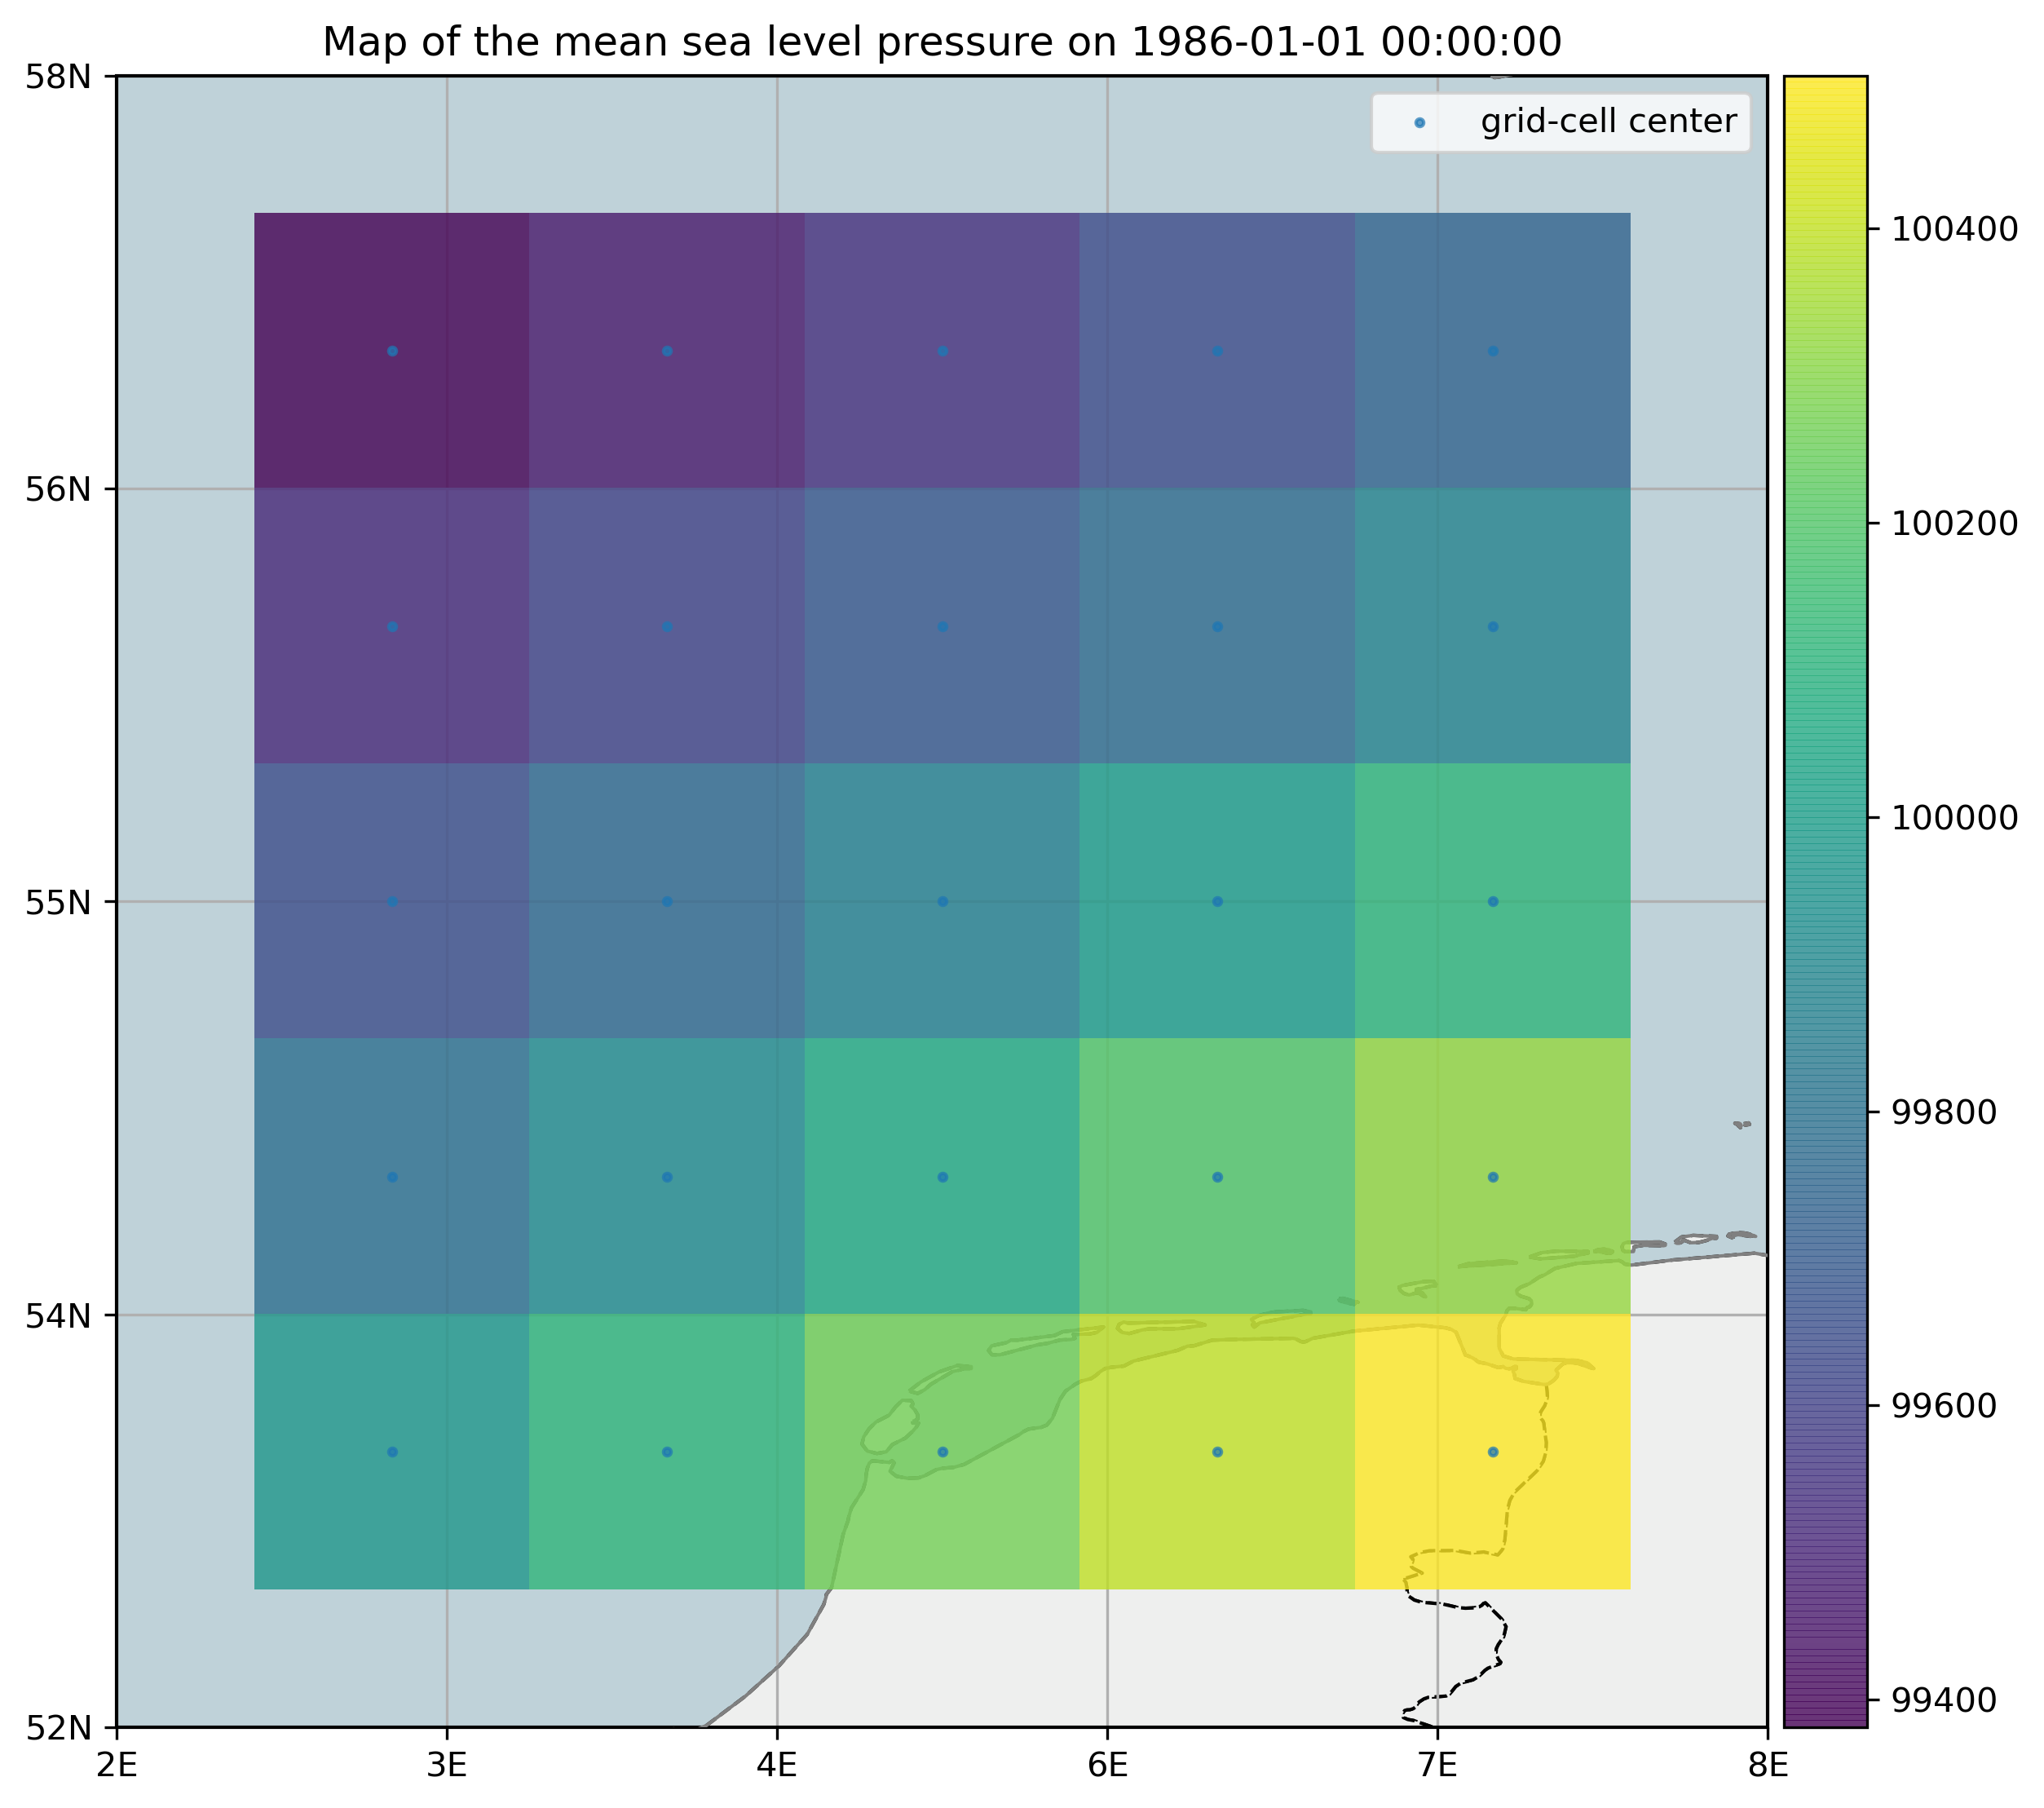

In [37]:
# verification: spatial map of the mean sea level pressure 

sel_type = 'pressure' # either pressure or gradient
sel_time = 0 # between 0-10 for gradient and 0-1000 for pressure

if sel_type == 'pressure':
    dataplot = spat_resampled_resultMSLP
if sel_type == 'gradient':
    dataplot = spat_resampled_resultGMSLP

# make plot
fig = plt.figure(figsize=(16, 9), dpi=300, facecolor='white')

# world map
ax = plt.axes([0, 0.12, 0.83, 0.75],projection=cartopy.crs.PlateCarree())
ax.grid()

_ = ax.set_xlim(min(dataplot['lon'][:])-1, max(dataplot['lon'][:])+1)                 
_ = ax.set_ylim(min(dataplot['lat'][:])-1, max(dataplot['lat'][:])+1) 
_ = ax.set_xticks(np.linspace(min(dataplot['lon'][:])-1, max(dataplot['lon'][:])+1, num=6), crs=cartopy.crs.PlateCarree()) 
_ = ax.set_yticks(np.linspace(min(dataplot['lat'])-1, max(dataplot['lat'])+1, num=5), crs=cartopy.crs.PlateCarree()) 
    
# Set RGB value to ocean colour '#bfd2d9' has 191, G:210, B:217 as 10m ocean cartopy import gives errors
ax.imshow(np.tile(np.array([[[191, 210, 217]]], dtype=np.uint8), [2, 2, 1]), origin='upper', transform=cartopy.crs.PlateCarree(), extent=[-180, 180, -180, 180])

# load features, add features and add axes
country_10m = cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m')
ax.add_feature(country_10m, edgecolor='k', linestyle='--', facecolor='#EEEFEE')
ax.coastlines(resolution='10m', color='grey', zorder=5);

lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='',
                                   dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

plotcoordx, plotcoordy = np.meshgrid(dataplot['lon'][:], dataplot['lat'][:])
ax.scatter(plotcoordx.flatten(),plotcoordy.flatten(), zorder=13,alpha=0.7,s=5, transform=cartopy.crs.PlateCarree(), label='grid-cell center');
plot = ax.imshow(dataplot['MSL'][sel_time].values, alpha=0.8, zorder = 12, extent=(dataplot['lon'].values[0]-0.5, dataplot['lon'].values[-1]+0.5, dataplot['lat'].values[0]+0.5, dataplot['lat'].values[-1]-0.5))

# plot the data
if sel_type == 'pressure':
    plt.title('Map of the mean sea level pressure on %s %s'%(str(dataplot['time'][sel_time].values)[0:10], str(dataplot['time'][sel_time].values)[11:19]));
if sel_type == 'gradient':
    plt.title('Map of the spatial gradient of the mean sea level pressure on %s %s'%(str(dataplot['time'][sel_time].values)[0:10], str(dataplot['time'][sel_time].values)[11:19]));
fig.colorbar(plot, pad=0.005)
plt.legend();

# 3. Predictor Definition

Make use of the following functions:
5. preditor_definition (pde)

Task 7a. Aggregation of atmospheric data correlated with wave generation (averaged during 1 day). For computing daily running means of the 6h spatial fields.

In [39]:
help(pde.PredictorDefinition.atmospheric_averaged_mean)

Help on function atmospheric_averaged_mean in module SDToolBox.predictor_definition:

atmospheric_averaged_mean(dataset: xarray.core.dataset.Dataset, t_days: int = 0, t_hours: int = 0) -> xarray.core.dataset.Dataset
    Calculates the average mean for the given dataset
    within the input time window.
    
    Arguments:
        dataset {xr.Dataset} -- xArray dataset.
    
    Returns:
        xr.Dataset -- Predictor result.



In [60]:
# atmospheric_averaged_mean
atm_a_m = pde.PredictorDefinition.atmospheric_averaged_mean(dataset = ERA5BOXMSL_check3,
                                                            t_days = 1,
                                                            t_hours = 6)

print(atm_a_m)
#print(np.datetime64(ERA5BOXMSL.time[0]+timedelta(days=1,hours=6)))
#print(ERA5BOXMSL.time[0]+np.timedelta(days=1, hours=6))

<xarray.Dataset>
Dimensions:  (lat: 19, lon: 19, time: 970)
Coordinates:
  * time     (time) datetime64[ns] 1986-01-02T06:00:00 ... 1986-02-11T15:00:00
  * lat      (lat) float32 57.0 56.75 56.5 56.25 56.0 ... 53.25 53.0 52.75 52.5
  * lon      (lon) float32 3.0 3.25 3.5 3.75 4.0 4.25 ... 6.5 6.75 7.0 7.25 7.5
Data variables:
    MSL      (time, lat, lon) float64 9.897e+04 9.901e+04 ... 1.034e+05


Task 7b. If we are good with time, repeat task 7a with aggregation data option.

In [307]:
help(pde.PredictorDefinition.atmospheric_aggregated)

Help on function atmospheric_aggregated in module SDToolBox.predictor_definition:

atmospheric_aggregated(dataset: xarray.core.dataset.Dataset, time_scale: int, var_list=None) -> Tuple[xarray.core.dataset.Dataset, List[xarray.core.dataset.Dataset]]
    Calculates the aggregated atmospheric predictor
    given a time_scale parameter (in days).
    
    Arguments:
        dataset {xr.Dataset} -- Input dataset.
        time_scale {int} -- Days to calculate. (Default{None})
    
    Returns:
        Tuple[xr.Dataset, List[xr.Dataset]]
            -- Output tuple with the resulting dataset
            delimeted by time and a list of the variables
            predictors.



In [46]:
# perform aggregation data option (atmospheric_aggregated) (SOLVED on the newest update)
atm_agg = pde.PredictorDefinition.atmospheric_aggregated(dataset = ERA5BOXMSL_check3,
                                                        time_scale = 8760,
                                                        var_list = ['MSL'])

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('O')

In [ ]:
# verification: for a point in the grid plot temporal series

In [ ]:
# verification: spatial map of the mean sea level pressure and gradient

Task 8a. Perform Principal Component Analysis on the temporal and spatial fields of mean sea level pressure and the squared gradient. The function returns the Empirical orthogonal functions (EOF) and the principal components (PCs)

In [317]:
help(pde.PredictorDefinition.compute_PCA)

Help on function compute_PCA in module SDToolBox.predictor_definition:

compute_PCA(data_set: xarray.core.dataset.Dataset)
    Computes the Pricipal Component Analysis.
    
    Arguments:
        data array {xr.DataArray} -- DataArray for
        the gradients computation.
    
    Raises:
        Exception: When no arguments are given.
    
    Returns:
        pca mean, std deviation and variance



In [61]:
# predictor_definition library -> compute_PCA
#tester = xr.DataArray(
#            np.linspace(0, 11, num=12),
#            coords=[
#                pd.date_range(
#                    '15/12/1999',
#                    periods=12,
#                    freq=pd.DateOffset(months=1))
#                ],
#            dims='time')
#grad2slp = np.random.rand(10,3,4)
#slp = np.random.rand(10,3,4)
#
#tester.attrs['slp'] = slp
#tester.attrs['grad2slp'] = grad2slp

#print(tester)
#print(ERA5BOXMSL)
#ERA5BOXMSL.attrs['MSL'] = ERA5BOXMSL['MSL'].values
#print(ERA5BOXMSL)

[PCAmean, PCAstd, PCAvar] = pde.PredictorDefinition.compute_PCA(data_set = ERA5BOXMSL)

Exception: Attribute not in dataset

In [354]:
ERA5BOXMSL['MSL'].values

array([[[-197.58    , -258.74    ],
        [ 152.59999 ,  -75.13    ]],

       [[-211.75    , -290.63    ],
        [ 152.59999 ,  -79.38    ]],

       [[-208.44    , -262.52    ],
        [  96.6     , -122.619995]],

       ...,

       [[ -23.39    , -116.74    ],
        [-171.25    ,  139.4     ]],

       [[  60.02    ,  -13.259999],
        [-115.5     ,  186.18    ]],

       [[ 178.15    ,  155.2     ],
        [-111.009995,  229.65    ]]], dtype=float32)

In [ ]:
# verification: plot EOFs (spatial map) and PCs (temporal series)

# 4. Statistical Model

Make use of the following functions:
5. preditor_definition (pde)

Task 8b. Compute Principal Component Analysis on the different coastal locations with wave climate (if we are doing well with time). If this task is not done, continue selecting only one wave station in the coast.

In [ ]:
# (statistical model function)?

In [ ]:
# verification: plot EOFs (spatial map) and PCs (temporal series)

Task 9. Normalization of the predictor data (X, they will be the PCs) using Z score method

Task 10. Define calibration and validation subsets with stratified K folds, try with 5 splits (80% calibration; 20% validation) and 2 repetitions to start with.

In [6]:
# verification: Plot temporal series of wave climate selected for calibration and validation.
# (can be using different colors on the same plot).

Task 11. Train the multivariate regression model (Y=alpha0+sum(alphai*Xi)), the predictand Y = Significant wave height, the predictor X= normalized PCs

In [ ]:
# verification: Check which PCs are significative (which numbers are in the model)
# Plot scatter X,Y empirical and X,Y* modelled, for the training subset and the validation subset 
# (you can do this very simply using the average of the coefficients of the 8 models defined, (5-1)splits*2repetitions)

Task 12. Compute accuracy scores for the stratified folds taken for validating

In [ ]:
# (there are functions defined for this in the library statistical model, get_all_scorers())

In [ ]:
# verification: table with scores

Task 13. Repeat 10, 11 and 12 but with wave direction, because the regression model for circular variables is different

In [ ]:
# ..

In [ ]:
# verifications: ...

# 5. Application: Future Wave Projections

In [ ]:
# to be continued